In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from __future__ import division

import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import healpy as hp
import multiprocessing as mp

import enterprise

from enterprise.pulsar import Pulsar

from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise import constants as const
from enterprise.signals.signal_base import LogLikelihood

from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler
from enterprise_extensions import blocks as ee_blocks
from enterprise_extensions import deterministic as ee_deterministic

import skyplot_tools as spt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Do not have acor package


In [17]:
def make_Mmat(psr):
    DesignM = np.ones((len(psr.toas), 3))
    DesignM[:,1] = psr.toas
    DesignM[:,2] = DesignM[:,1]**2
    return DesignM
def make_Rmat(psr):
    I = np.identity(len(psr.toas))
    DesignM = make_Mmat(psr)
    return I - np.einsum('kn,nm,pm->kp', DesignM, np.linalg.inv(np.einsum('km,kn->nm',DesignM,DesignM)),DesignM)
            
def fit_resids(psr):
    R = make_Rmat(psr)
    psr._residuals = R@psr.residuals

In [3]:
fake_pardir = './12.5yr_blankresids/NANOparfiles/'
fake_timdir = './12.5yr_blankresids/NOGWB/'

parfiles = sorted(glob.glob(fake_pardir + "*.par"))
timfiles = sorted(glob.glob(fake_timdir + "*.tim"))

In [4]:
sim_psrs = []
for p,t in zip(parfiles, timfiles):
    sim_psrs.append(Pulsar(p,t,ephem=None, clk=None))

[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  ECL
[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. ../NANOparfiles/B1855+09.par
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


Pre-fit residuals

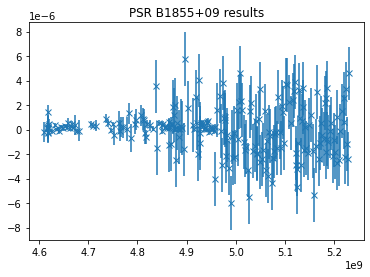

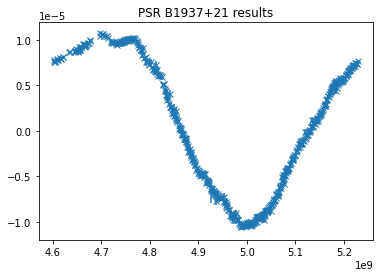

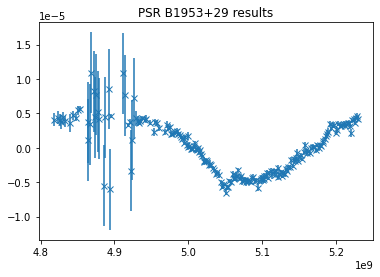

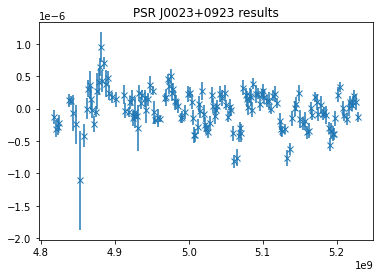

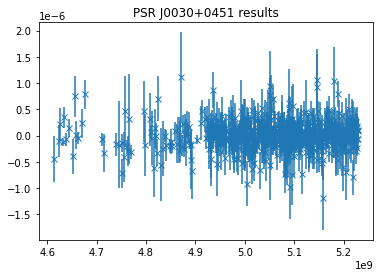

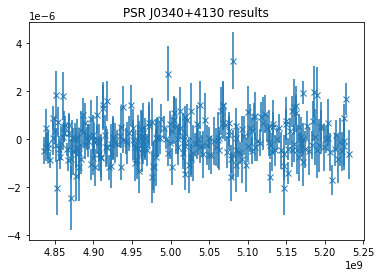

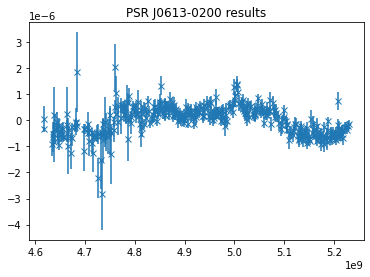

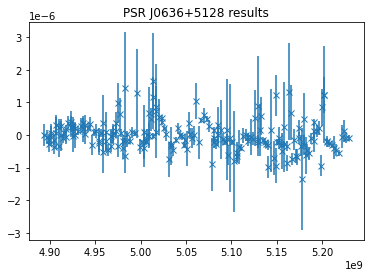

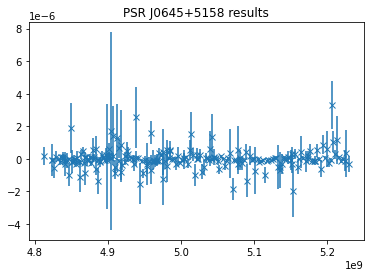

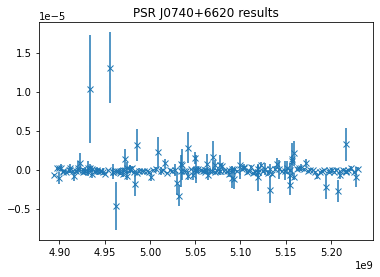

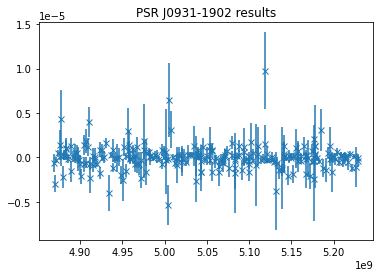

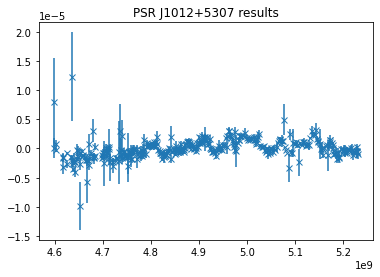

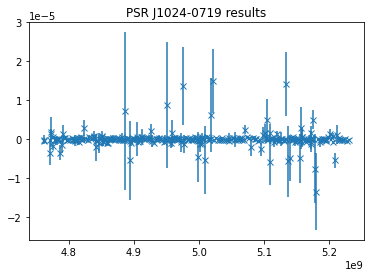

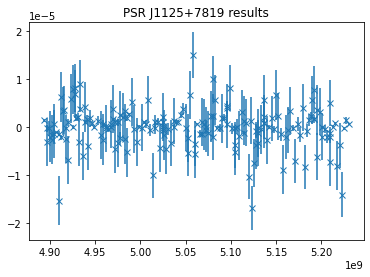

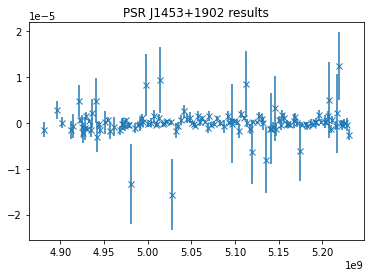

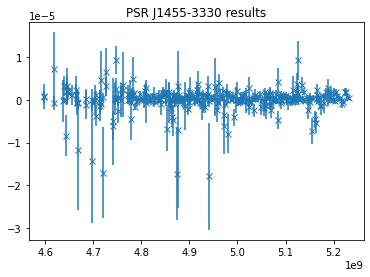

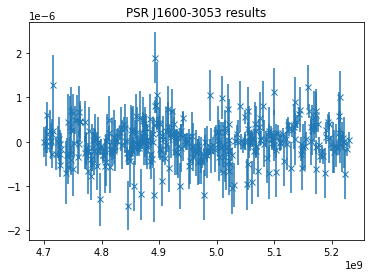

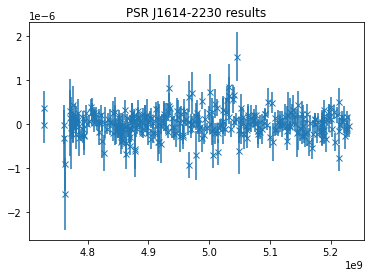

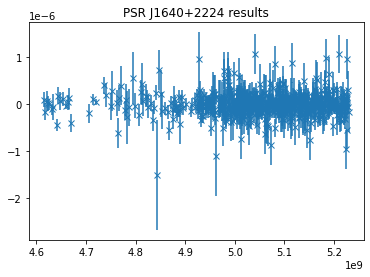

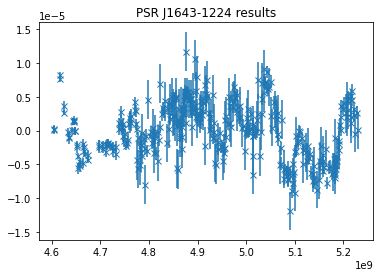

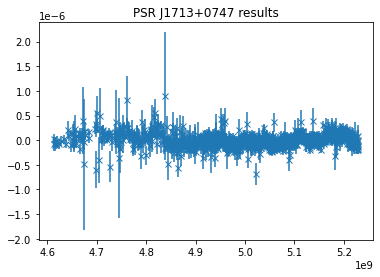

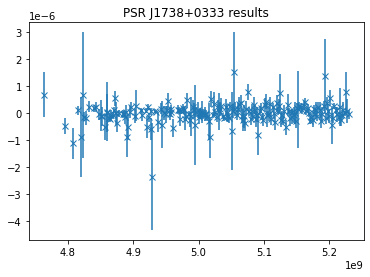

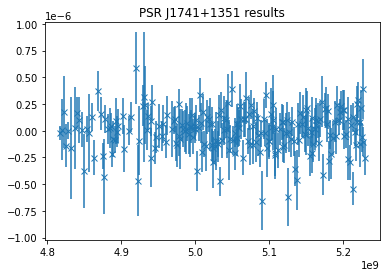

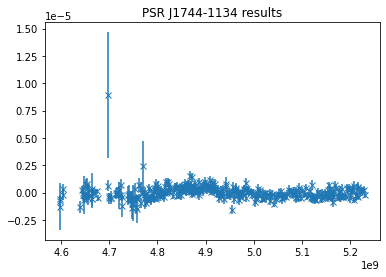

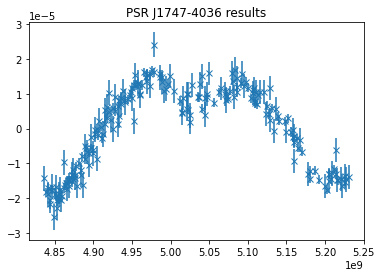

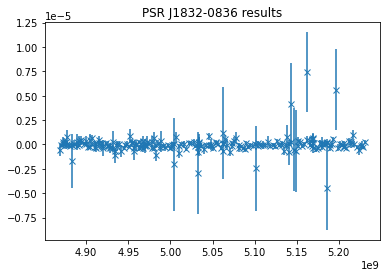

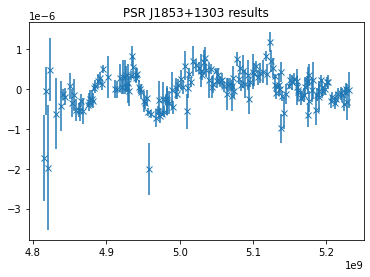

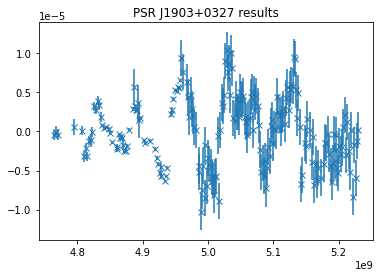

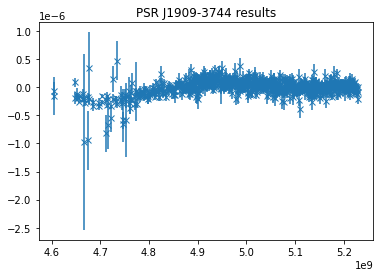

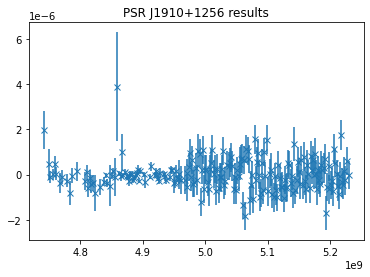

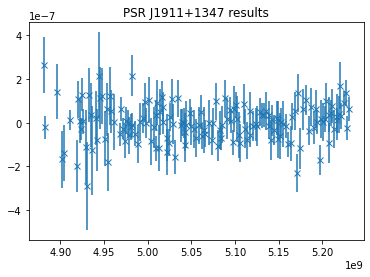

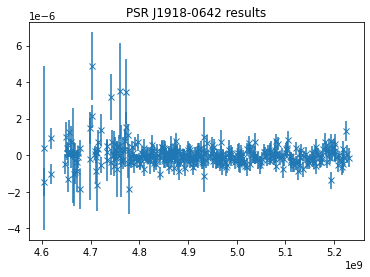

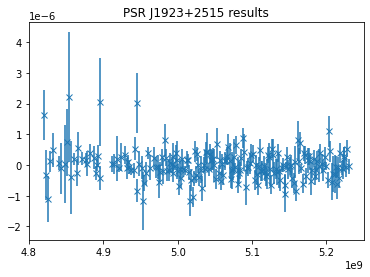

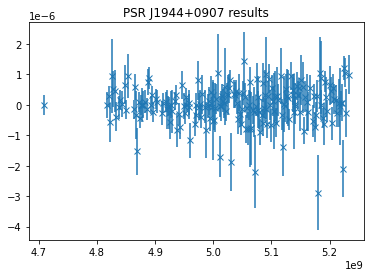

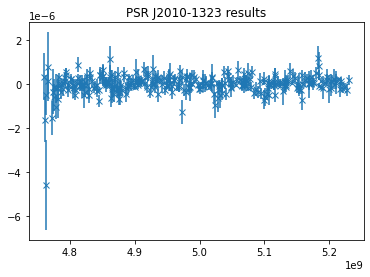

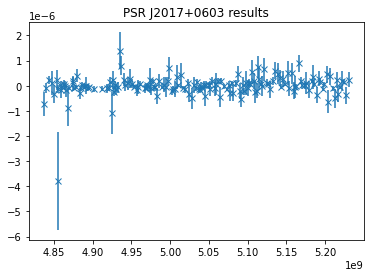

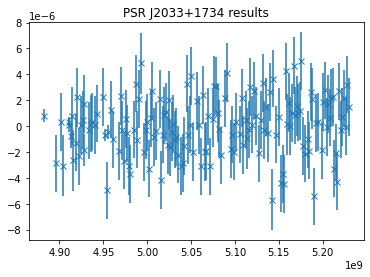

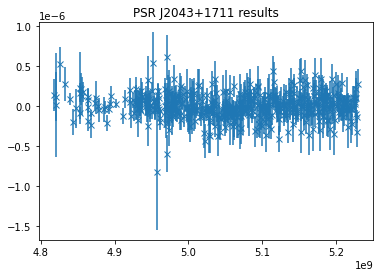

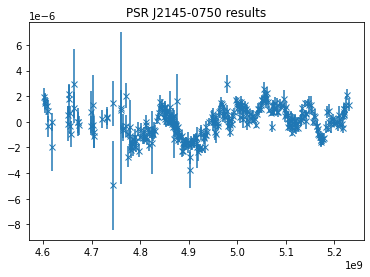

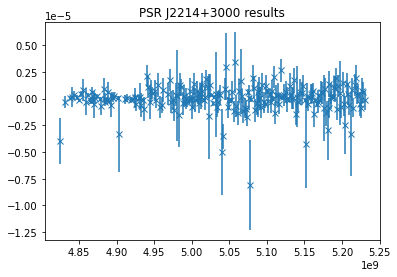

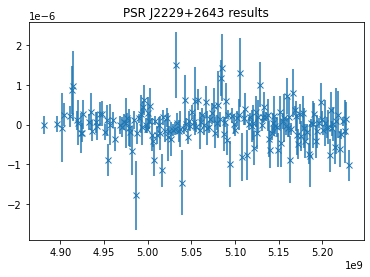

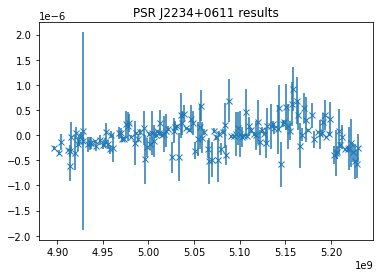

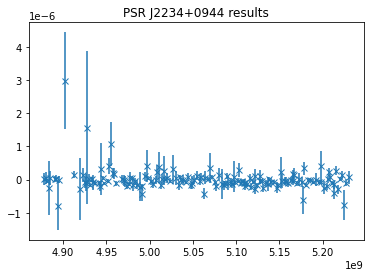

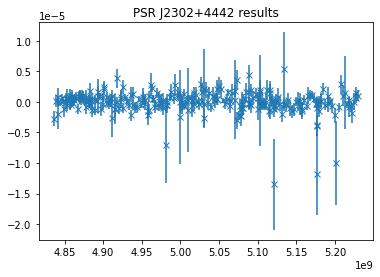

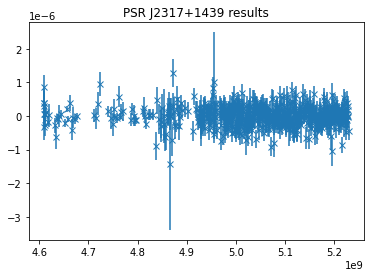

In [5]:
for psr in sim_psrs:
    #plt.scatter(psr.toas, psr.residuals, marker='x')
    plt.errorbar(psr.toas, psr.residuals, yerr = psr.toaerrs, marker='x', ls='none')
    plt.title("PSR {} results".format(psr.name))
    plt.show()

In [6]:
def bwm_response(bwm_theta, bwm_phi, bwm_pol, psrpos):
    apc = utils.create_gw_antenna_pattern(psrpos, bwm_theta, bwm_phi)
    fp, fc = apc[0], apc[1]
    pol = np.cos(2 * bwm_pol) * fp + np.sin(2*bwm_pol) * fc
    return pol

In [7]:
nano12_psrlocs = []
for p in sim_psrs:
    ## locations are given in [phi, costheta]
    theta, phi = hp.vec2ang(p.pos)
    psrloc = [phi[0], np.cos(theta[0])]

    nano12_psrlocs.append(psrloc)
nano12_psrlocs = np.array(nano12_psrlocs)

In [8]:
for psr in sim_psrs:
    print((psr.toas.max() - psr.toas.min())/3600/34/365)

13.855746927039906
14.045279613365405
9.238993515437224
9.21374436022452
13.787554794383505
8.839332210398005
13.679380699827012
7.507390583413536
9.31751046274342
7.52733255141974
8.066483224498329
14.168456915655028
10.472823679616281
7.529092877249931
7.797754418255938
14.170701539958383
11.847759063833989
11.220965512284533
13.734918230416387
14.0100381668112
13.78665209582845
10.42213934816579
9.219134675745657
14.15476422399868
8.820091122662737
8.091893191823196
9.286012986348581
10.433360544249924
13.992567404009511
10.919186876110794
7.807120236063869
13.989667184107136
9.164068412705301
11.715006457951043
10.515329099036851
8.791249252340748
7.764559207836531
9.234329950652048
14.037613101751013
9.067697054720618
7.80550658385642
7.468985277624606
7.876928213106742
8.819342251461507
13.857871742679414


Start by making a deepcopy of these pulsars to use as fake pulsars

In [9]:
import copy

fake_psrs = []
for psr in sim_psrs:
    psr_copy = copy.deepcopy(psr)
    fake_psrs.append(psr_copy)

In [10]:
for fake_psr in fake_psrs:
    fake_resids = np.zeros(len(fake_psr.toas))
#     print(type(fake_psr))
    fake_psr._residuals = fake_resids
    
    

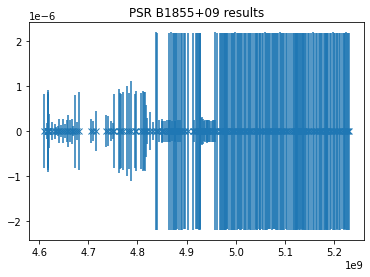

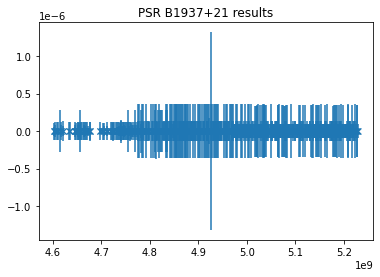

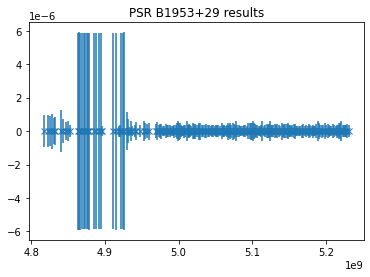

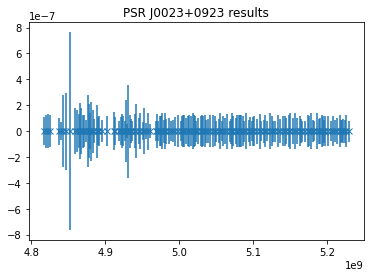

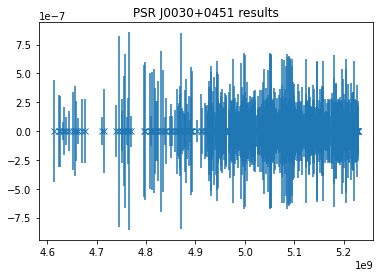

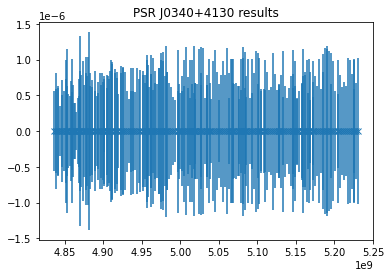

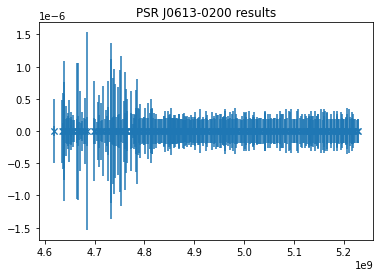

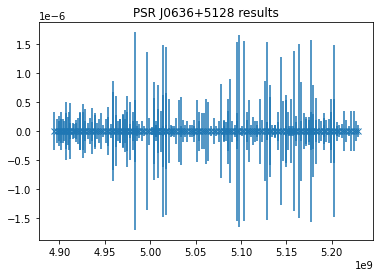

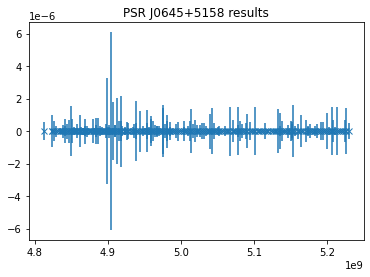

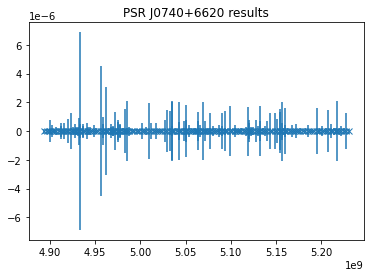

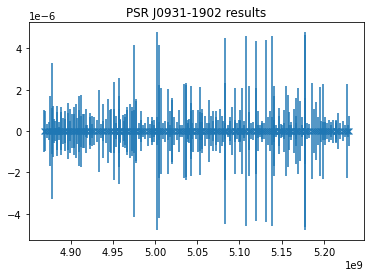

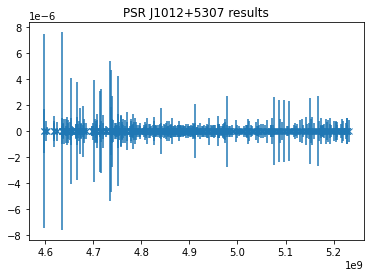

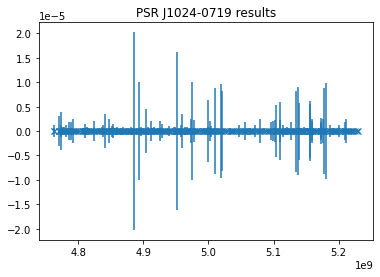

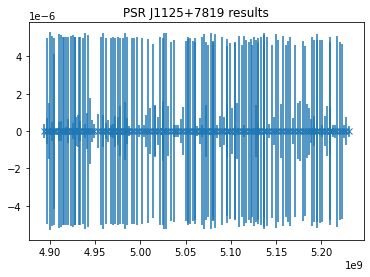

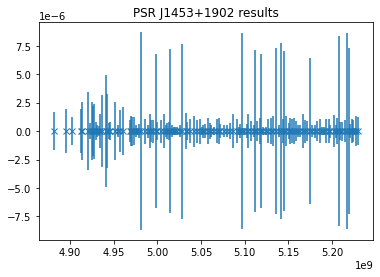

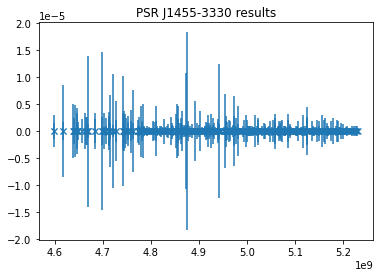

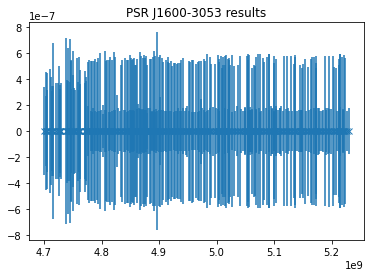

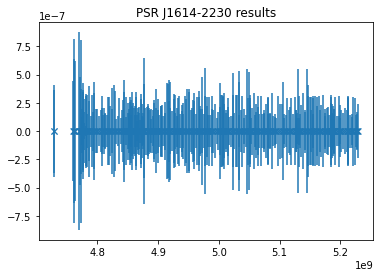

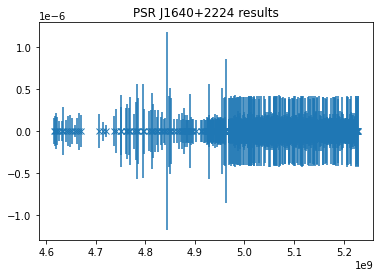

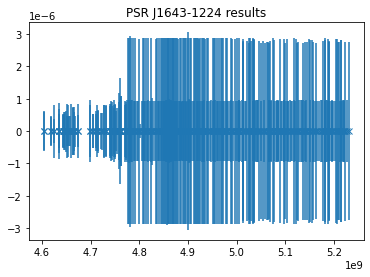

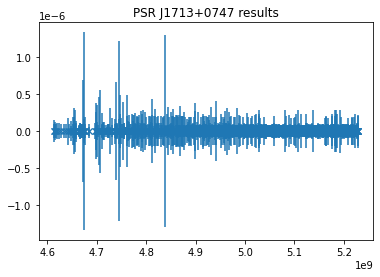

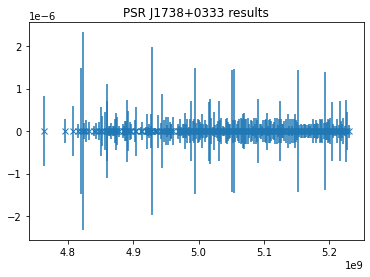

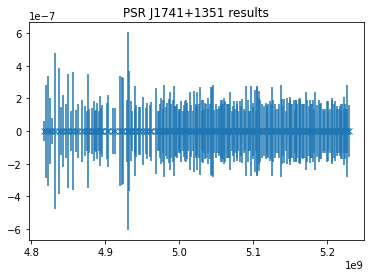

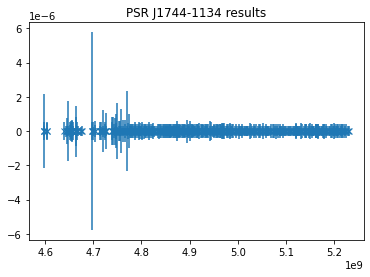

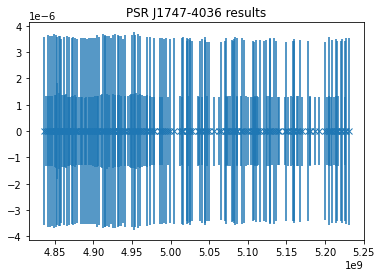

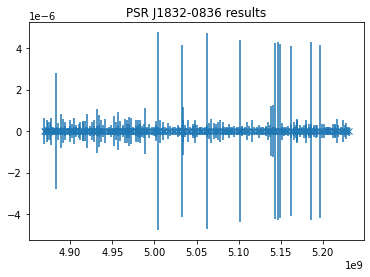

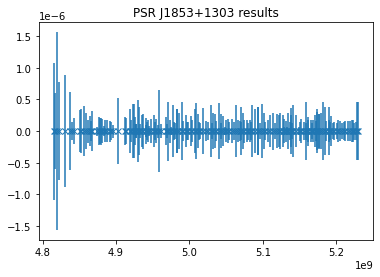

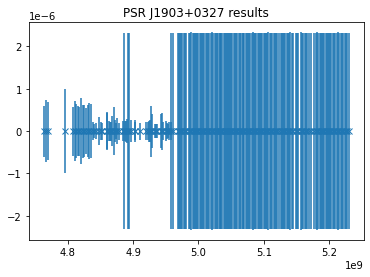

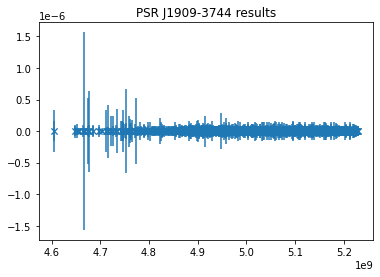

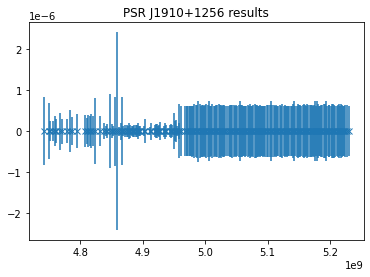

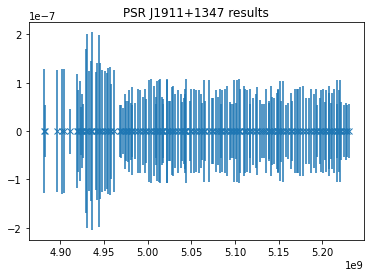

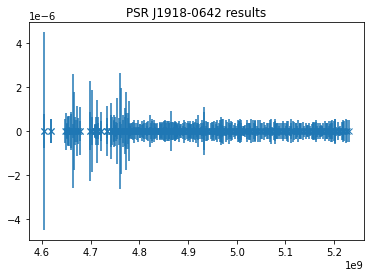

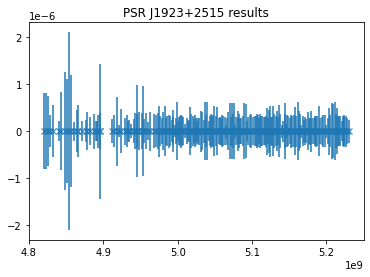

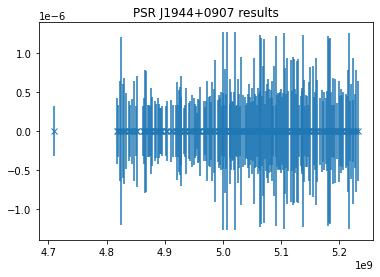

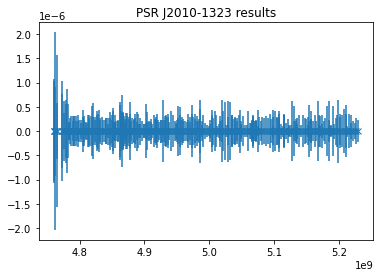

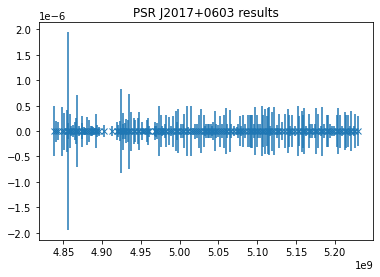

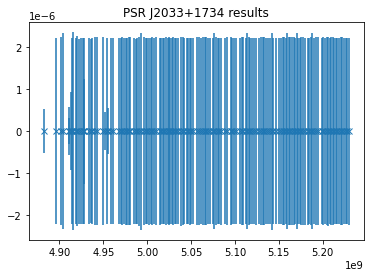

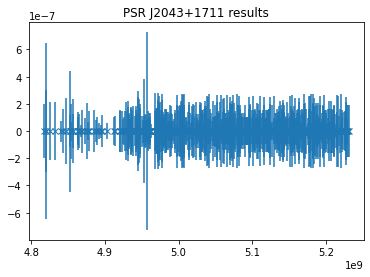

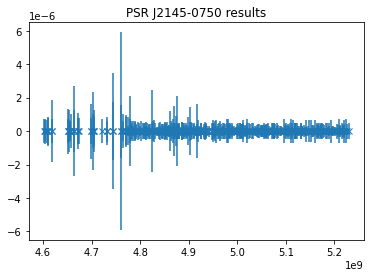

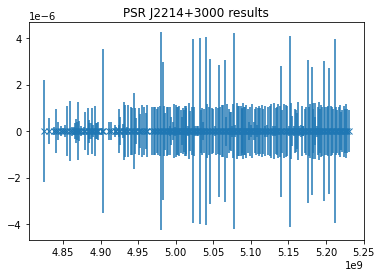

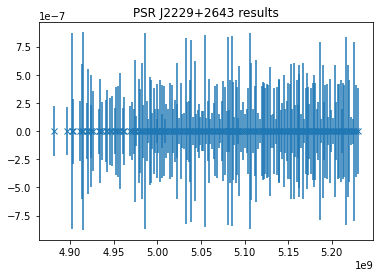

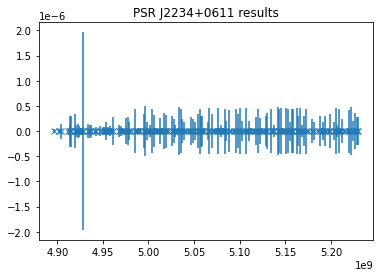

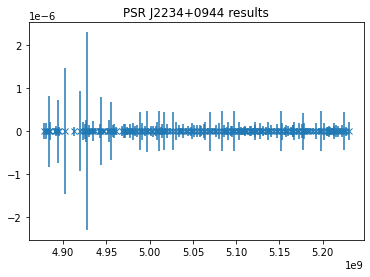

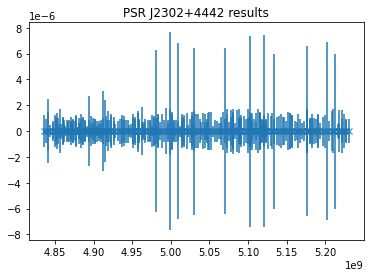

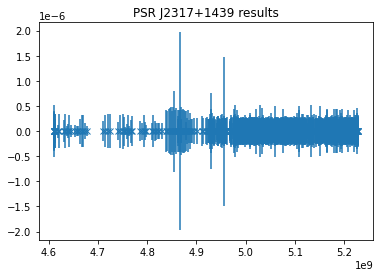

In [11]:
for fake_psr in fake_psrs:
    plt.errorbar(fake_psr.toas, fake_psr.residuals, yerr = fake_psr.toaerrs, marker='x', ls='none')
    plt.title("PSR {} results".format(fake_psr.name))
    plt.show()

Now let's make three data sets;
one with only WN and one with WN/CURN and one with WN/

SIM1. WN (100ns) only
SIM2. WN (100ns) and CURN at (l10A = -15, gamma = -5.5)
SIM3. WN (100ns) and BWM at (l10h = -14, t0=55000, pol=pi/4, loc=J1909)
SIM4. WN/CURN/BWM

with the plan being

0. Sglpsr free spectral analysis of SIM3
1. Full PTA Detection run of SIM3/4
2. Run full pipeline on SIM2 with the signal model including only WN+BWM
3. Run full pipeline on SIM2 with the signal model including WN + CURN (FG) + BWM

In [12]:
def make_rnseries_libstempo(psr, amplitude, spectral_idx, ncomponents=500, Tspan=100*365.25*24*3600):    
    day = 24*3600
    year = 365.25 * day
    
    t=psr.toas/24/3600
    minx, maxx = np.min(t), np.max(t)
    tspan = Tspan/3600/24
    x = (t - minx) / tspan
    T = Tspan/365.25/24/3600
    
    size = 2 * ncomponents
    F = np.zeros((len(psr.toas), size), "d")
    f = np.zeros(size, "d")

    for i in range(ncomponents):
        F[:, 2 * i] = np.cos(2 * np.pi * (i + 1) * x)
        F[:, 2 * i + 1] = np.sin(2 * np.pi * (i + 1) * x)

        f[2 * i] = f[2 * i + 1] = (i + 1) / T

    norm = amplitude**2 * year**2 / (12 * np.pi**2 * T)
    prior = norm * f ** (-spectral_idx)

    y = np.sqrt(prior) * np.random.randn(size)
    
    return F@y
    
def make_rednoise_fourier_coeffs(amplitude, spectral_idx, ncomponents=500, Tspan=100*365.25*24*3600):
    ref_freq = 1/(365.25 * 24 * 3600) #f_1yr
    a = np.zeros((ncomponents * 2))
    f_low = 1/Tspan

    # draw the coefficients first
    a = np.zeros(2*ncomponents) #vector of fourier coeffs, will always be sin/cos 
    comps = np.arange(1, ncomponents+1, 1) # needs to start at 1
    overall_norm = (amplitude ** 2) / (12 * np.pi**2)
    for comp in comps:
        freq_term = (comp * f_low / ref_freq) ** (-spectral_idx)
        sin_coeff = np.random.randn(1) * np.sqrt(overall_norm * freq_term)
        cos_coeff = np.random.randn(1) * np.sqrt(overall_norm * freq_term)
        
        a[2*(comp-1)] = sin_coeff
        a[2*(comp-1) + 1] = cos_coeff
        
    return a
    
def make_Fmat(psr, ncomponents=500, Tspan=100*365.25*24*3600):
    f_low = 1/Tspan
    
    Fmat = np.zeros((len(psr.toas),ncomponents*2))
    comps = np.arange(1, ncomponents+1, 1)
    
    init_toa = psr.toas.min()
    
    for toa_idx, toa in enumerate(psr.toas):
        for comp_idx, comp in enumerate(comps):
            f_comp = f_low * comp
            
            Fmat[toa_idx, 2*comp_idx] = np.sin(2 * np.pi * f_comp * (toa)) #sine component
            Fmat[toa_idx, 2*comp_idx + 1] = np.cos(2 * np.pi * f_comp * (toa))
            
    return Fmat

    
def make_wn_timeseries(psr, wn_level = 100e-9):
    return np.random.randn(len(psr.toas)) * wn_level

def make_bwm_timeseries(psr, bwm_h0, bwm_theta, bwm_phi, bwm_pol, bwm_epoch):
    psr_bwm_resp = bwm_response(bwm_theta, bwm_phi, bwm_pol, psr.pos)
    bwm_timeseries = [bwm_h0 * psr_bwm_resp * max(0, toa - bwm_epoch*24*3600) for toa in psr.toas]
    
    return np.array(bwm_timeseries)

OK! I think we're finally in position to produce the data sets.

SIM1. WN (100ns) only

SIM2. WN (100ns) and CURN at (A = 2e-15, gamma = -5.5)

SIM3. WN (100ns) and BWM at (l10h = -14, t0=55000, pol=pi/4, loc=J1909)

SIM4. WN/CURN/BWM

J1909-3744
-0.6508031345142838
4.966907693694703
Injected BWM Params:
Pol: 1.5707963267948966
Theta: 2.279438089253975
Phi: 4.966907693694703
Epoch: 58000


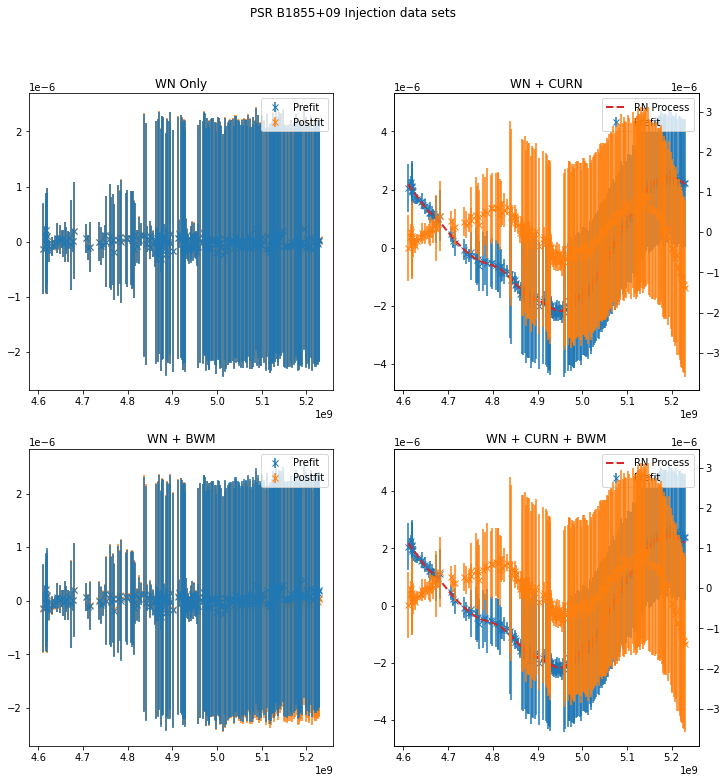

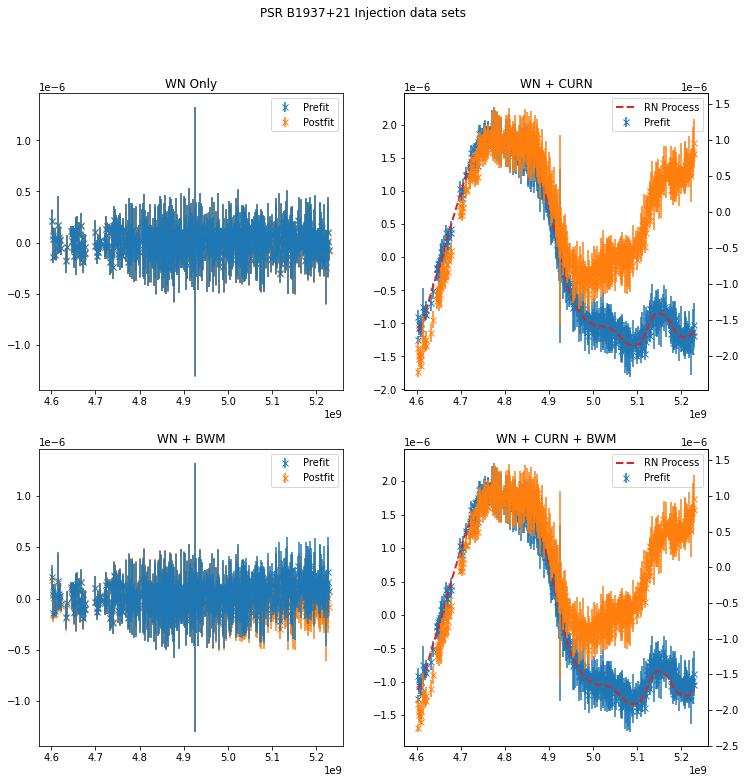

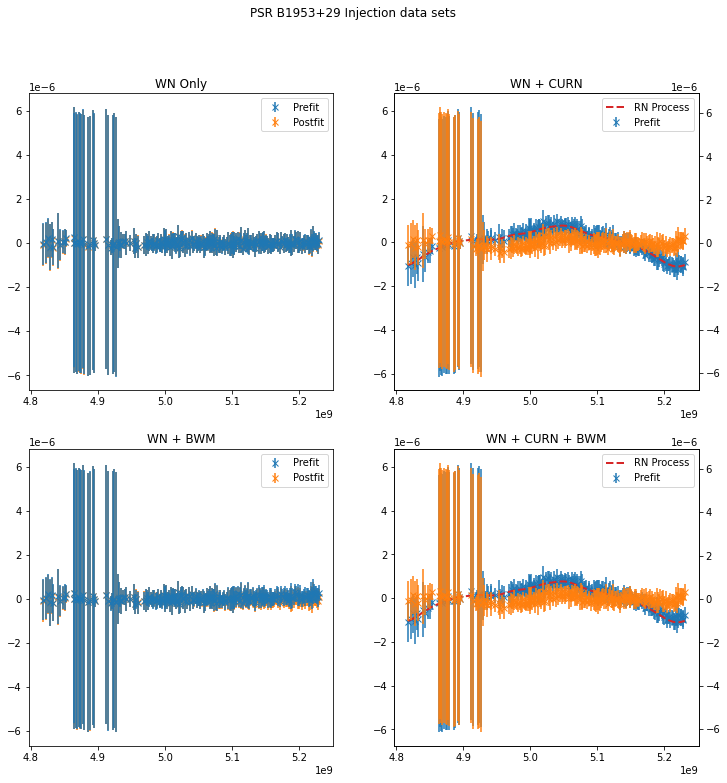

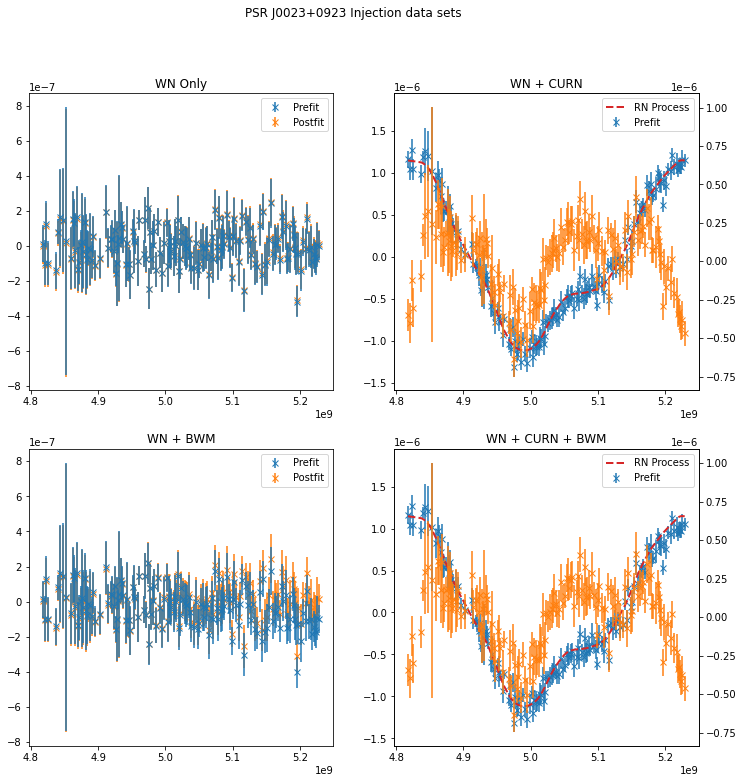

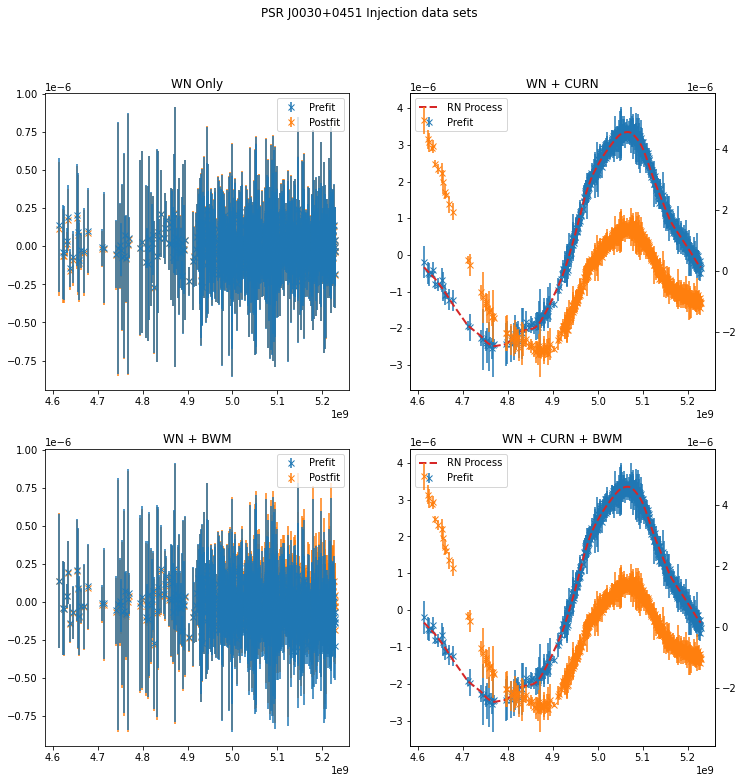

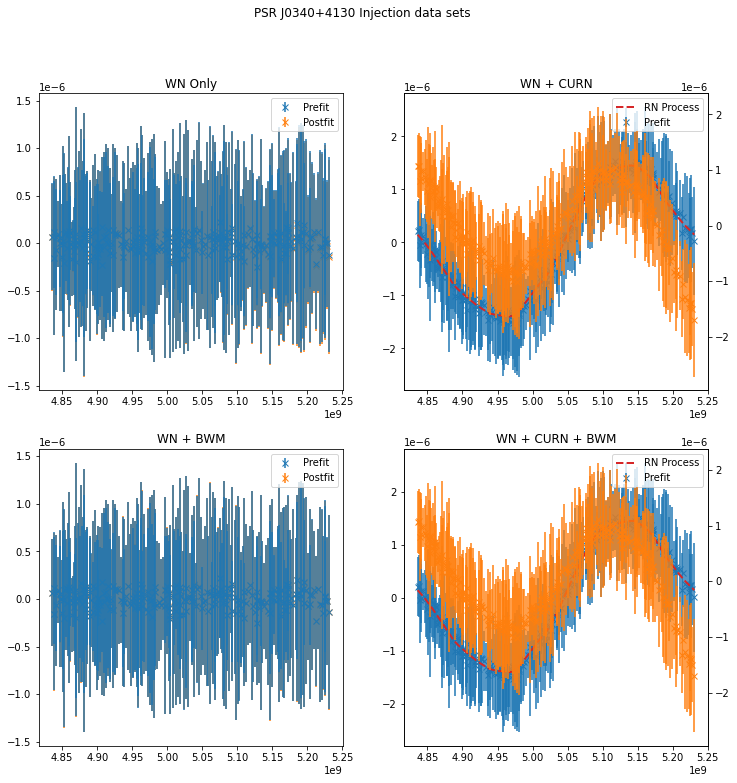

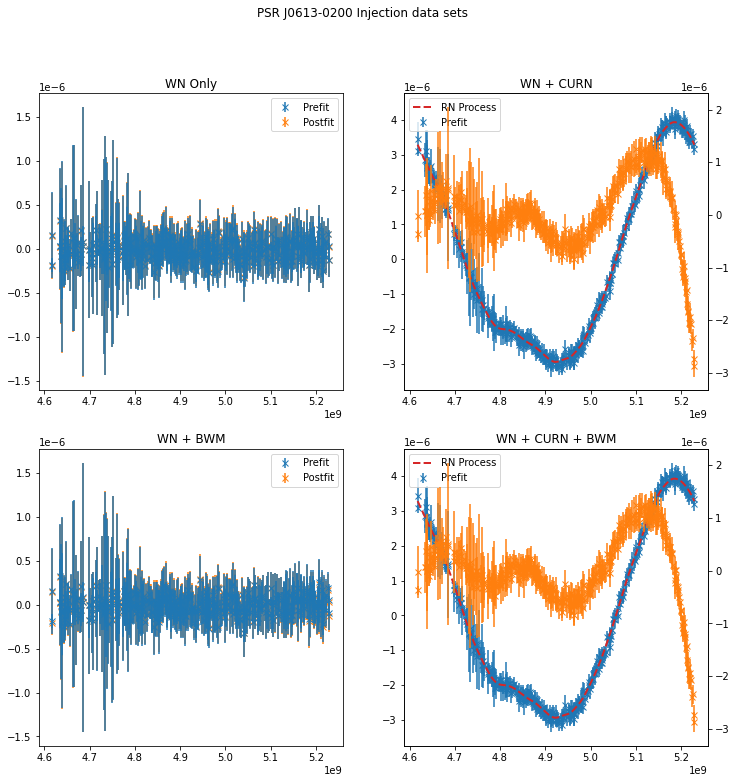

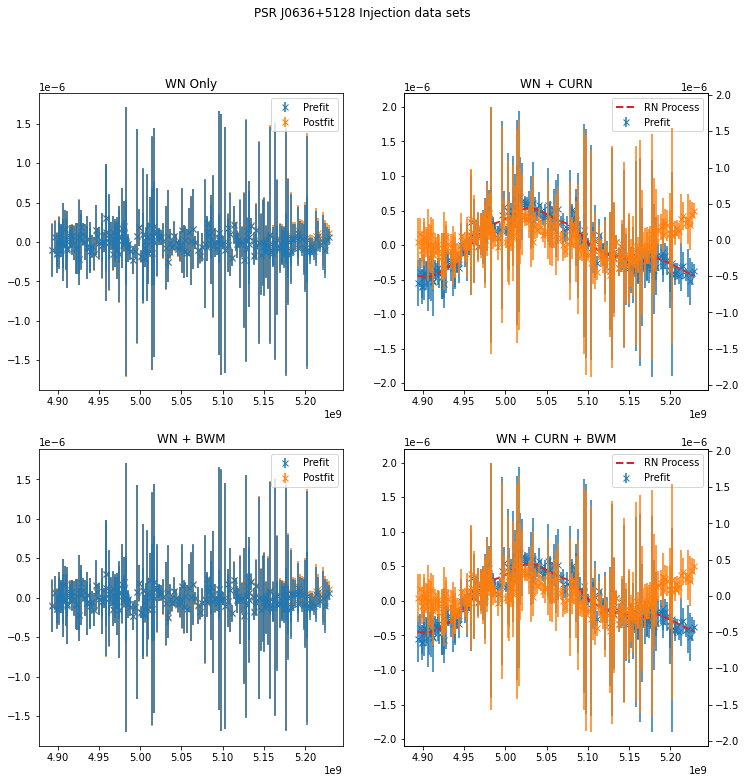

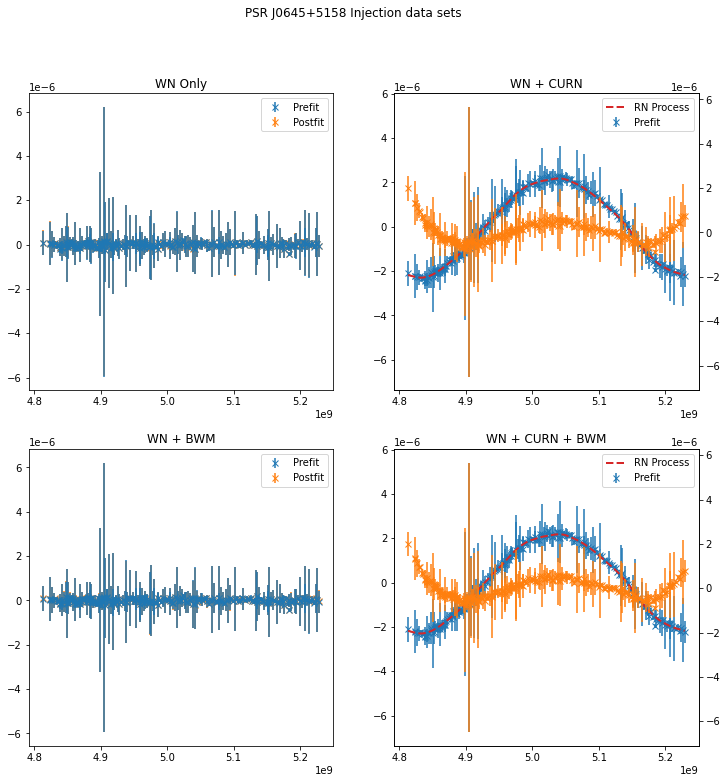

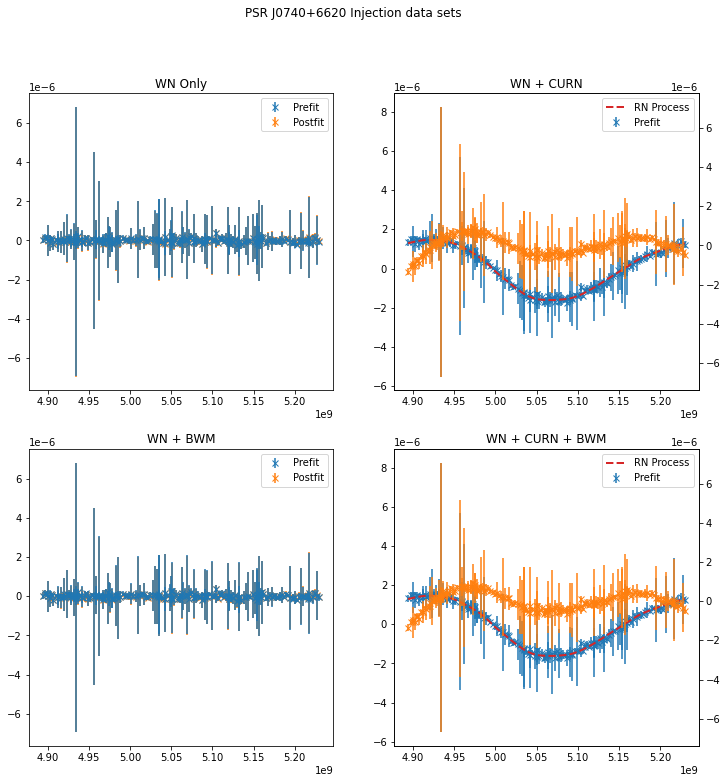

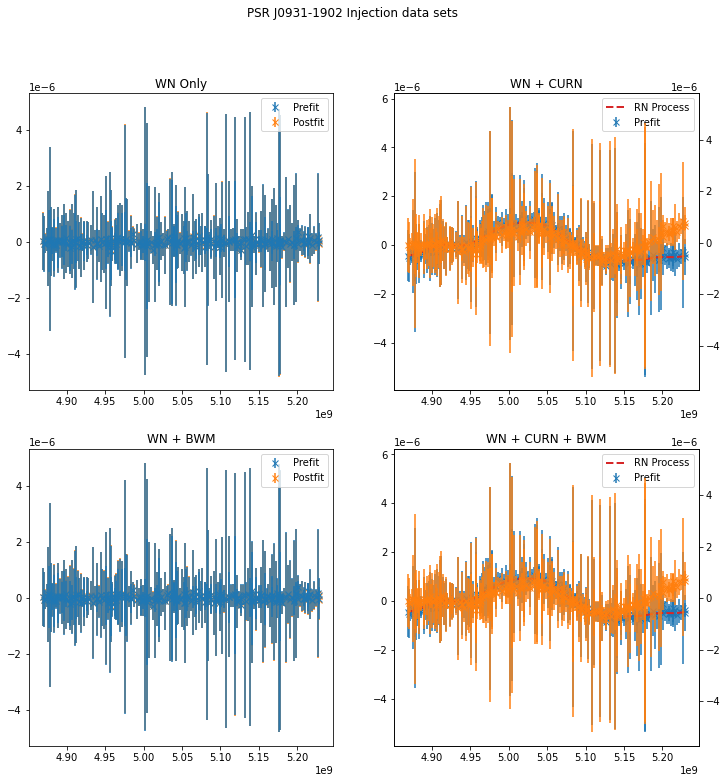

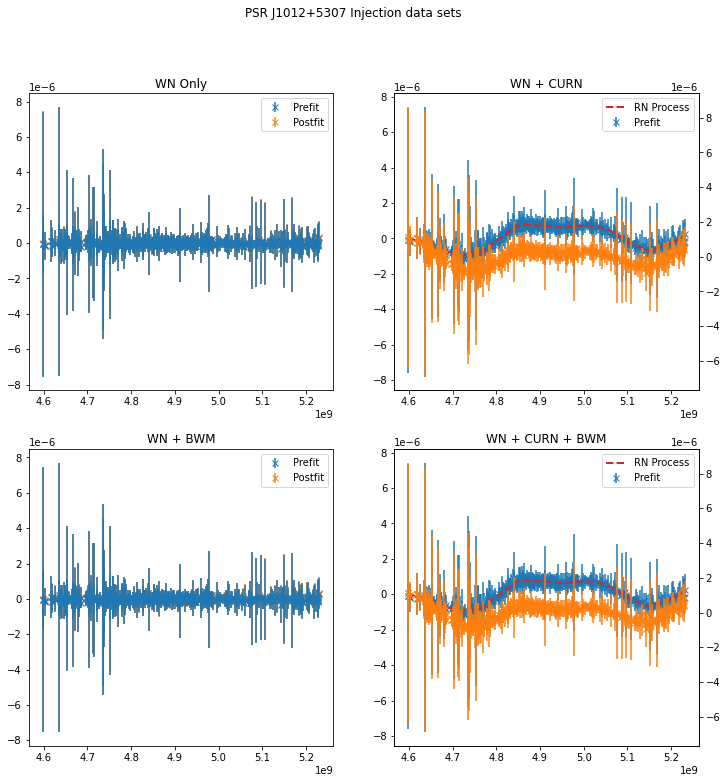

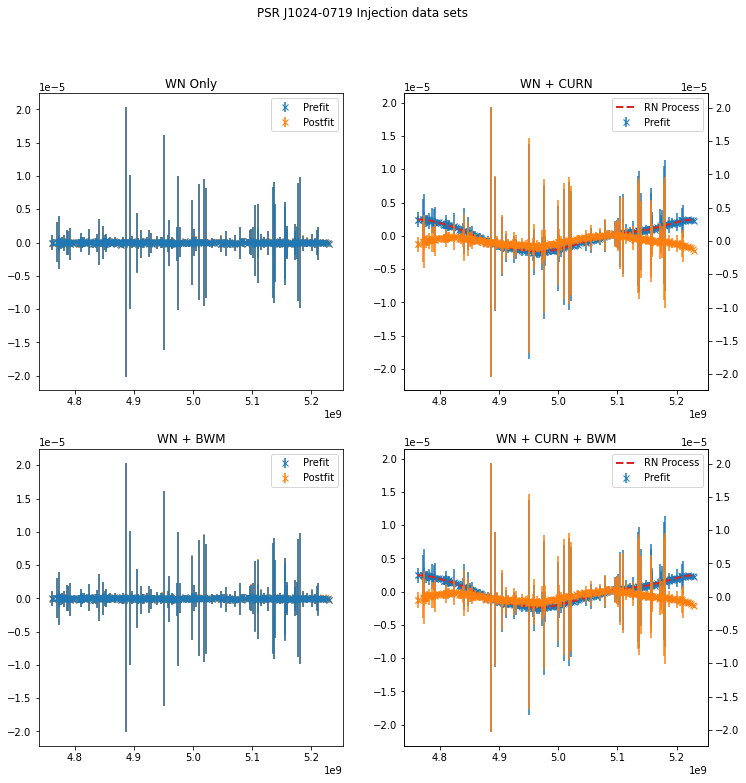

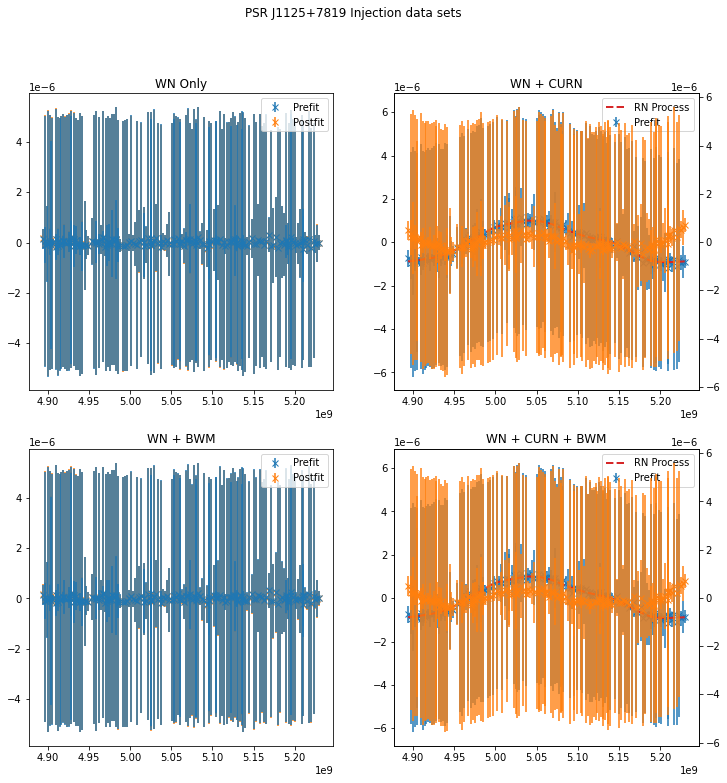

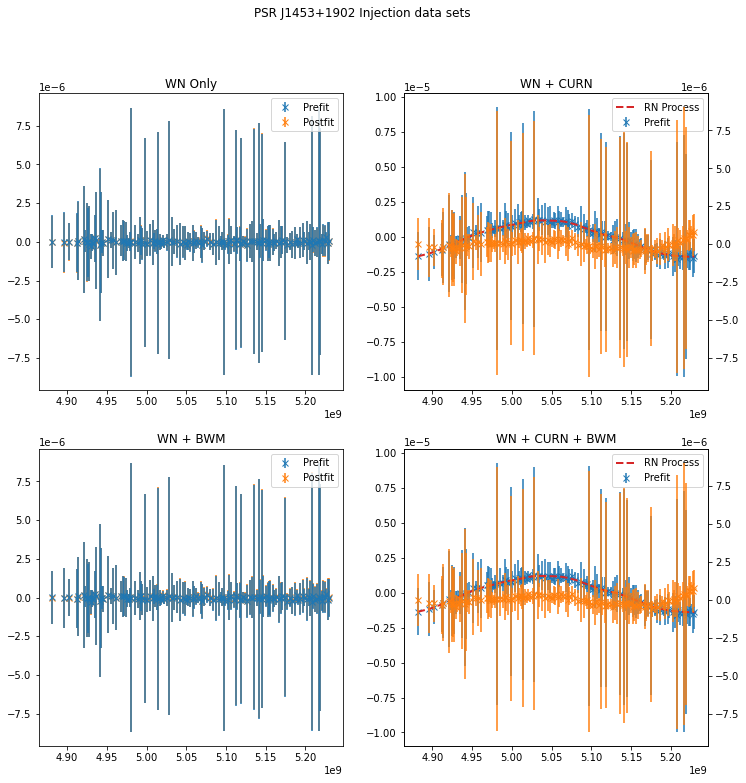

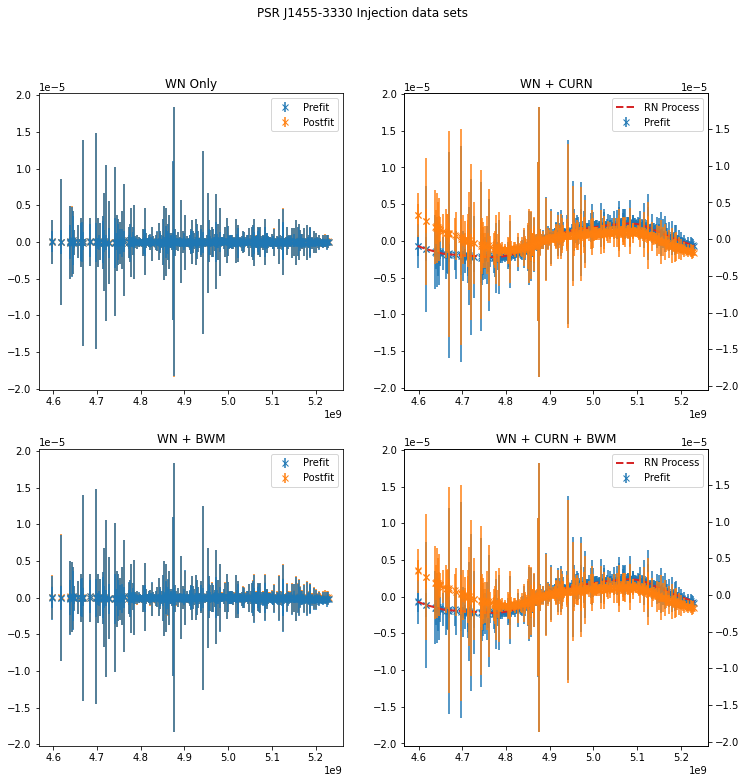

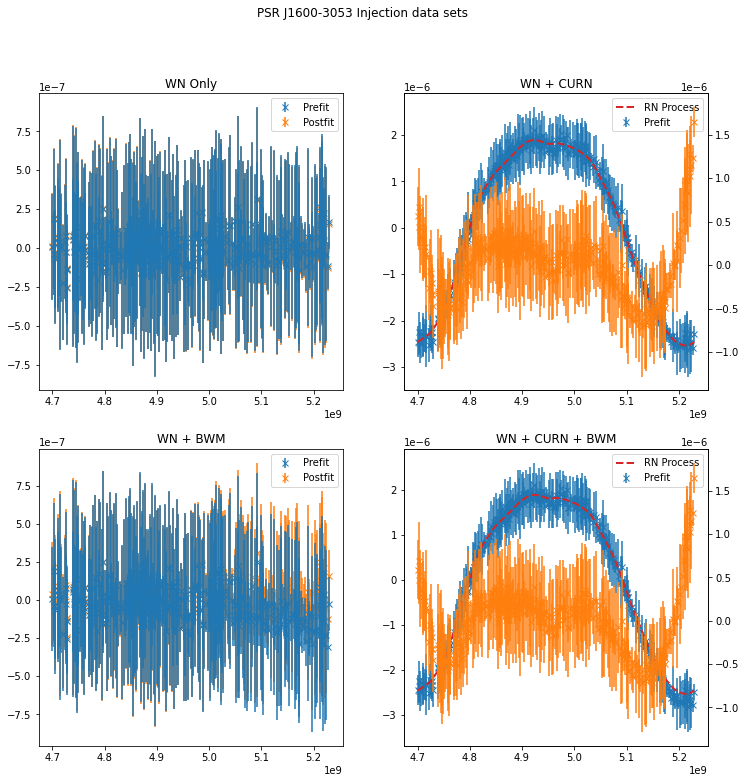

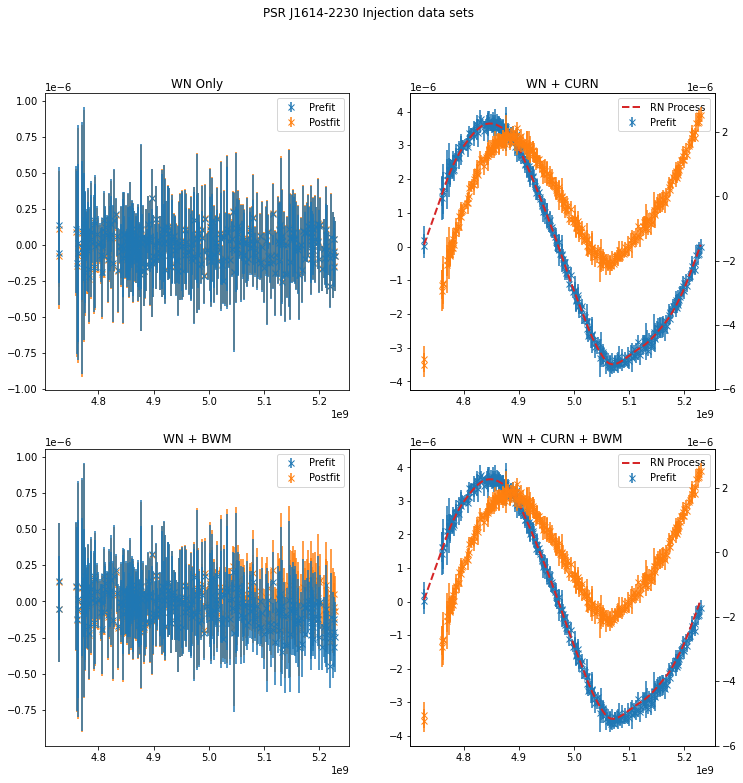

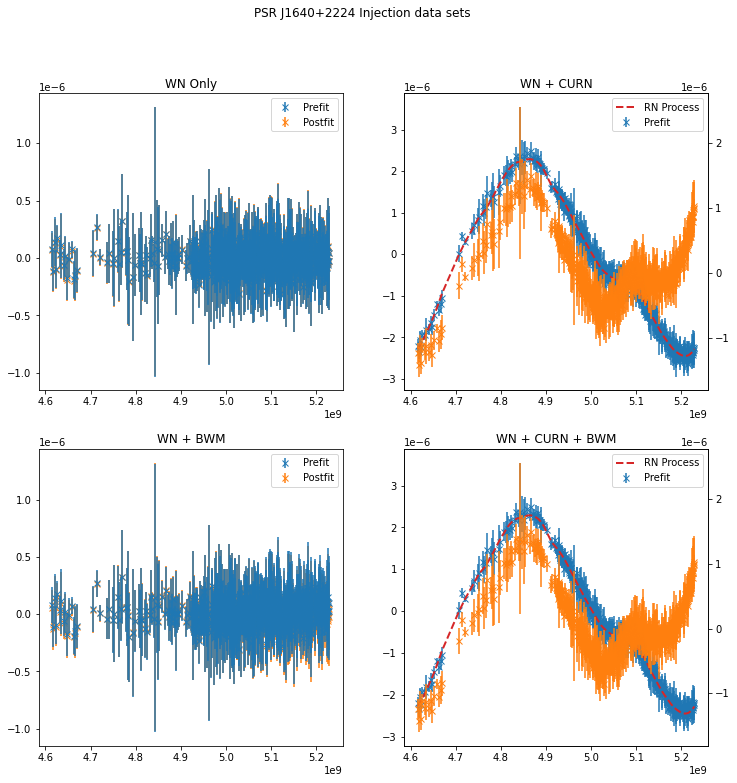

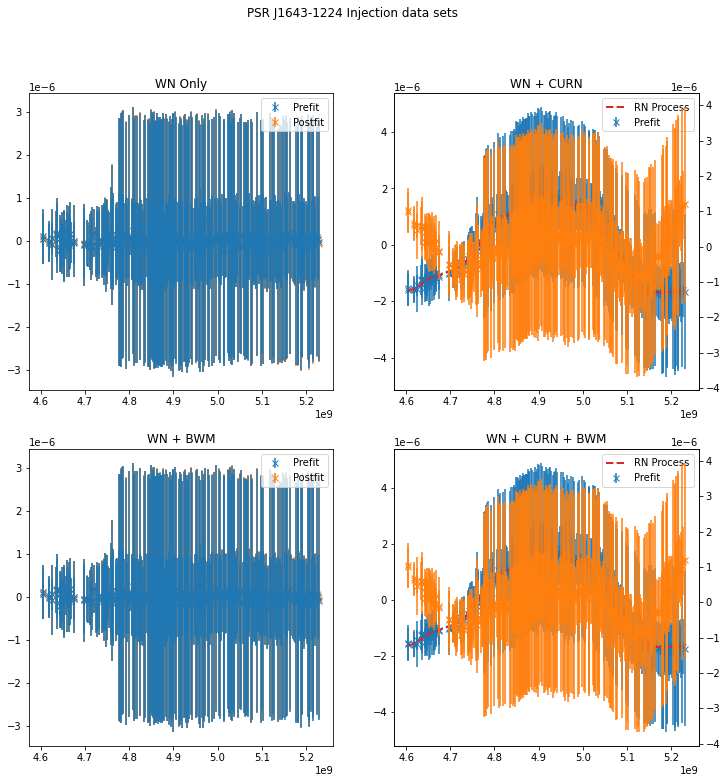

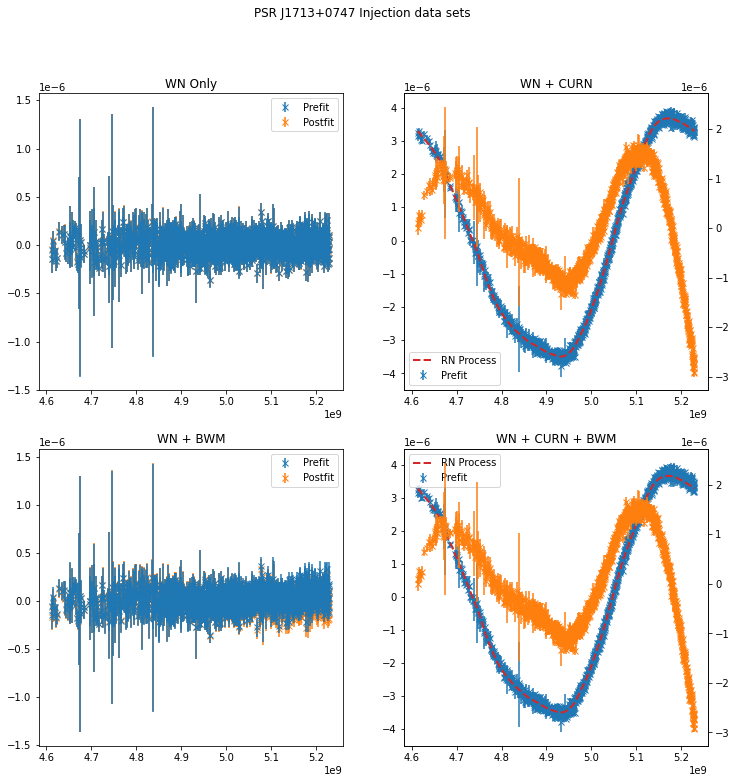

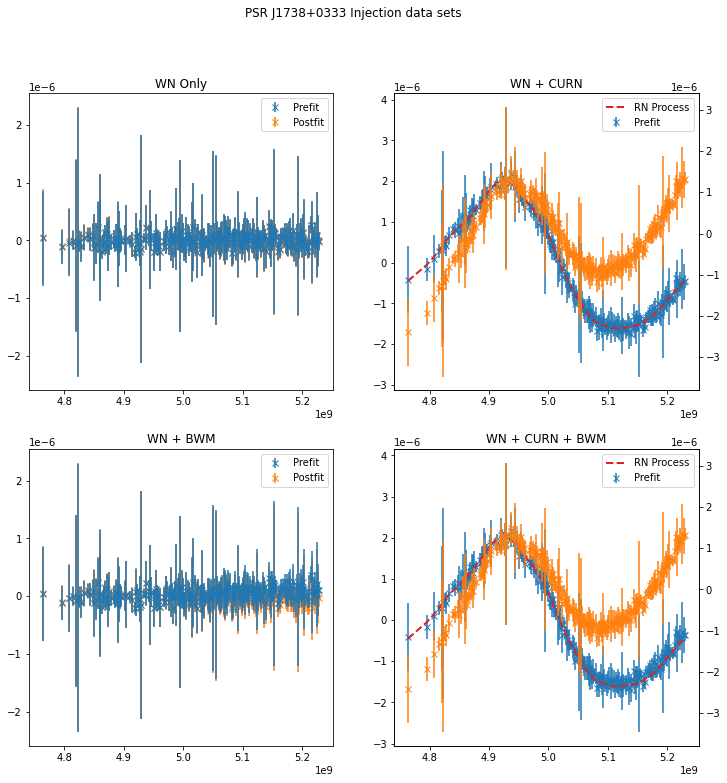

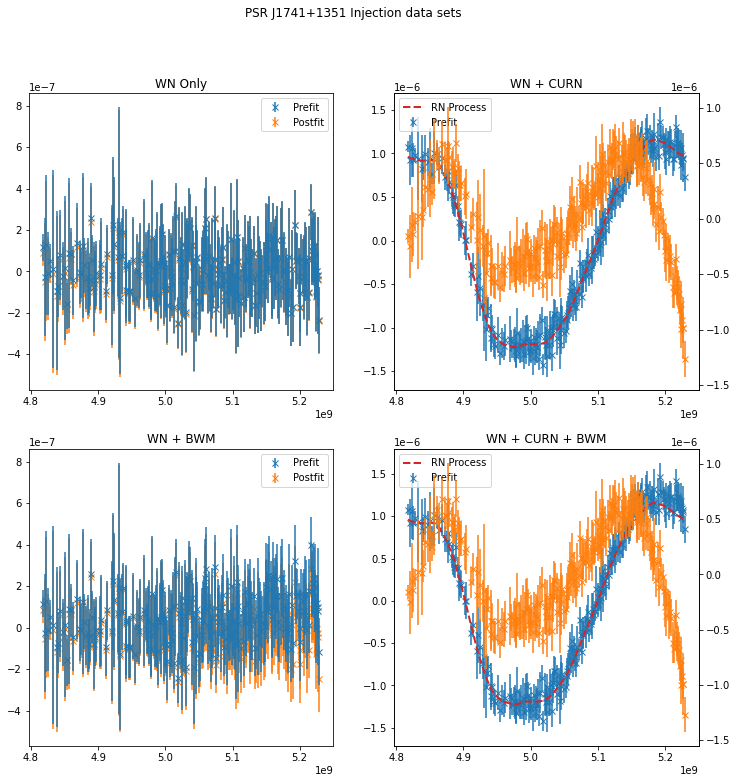

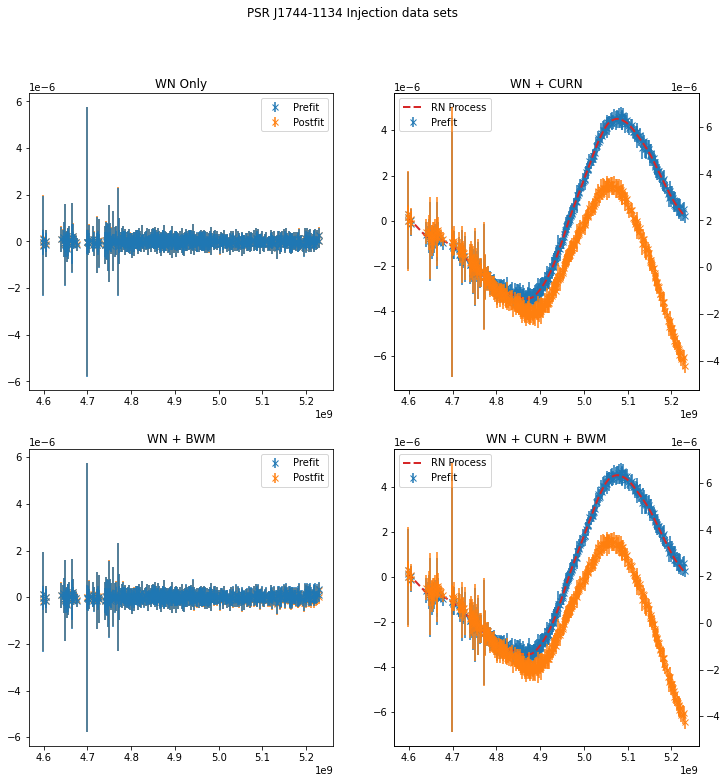

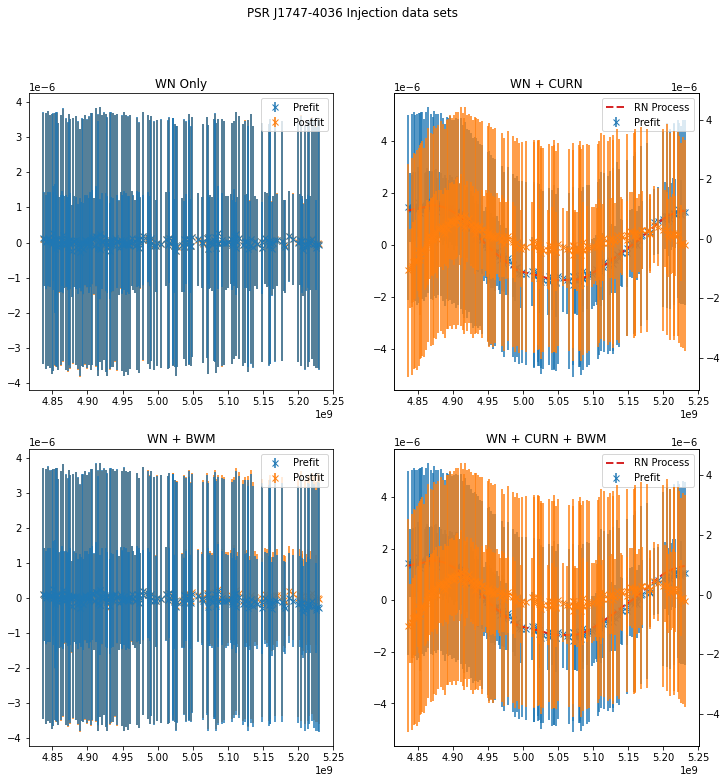

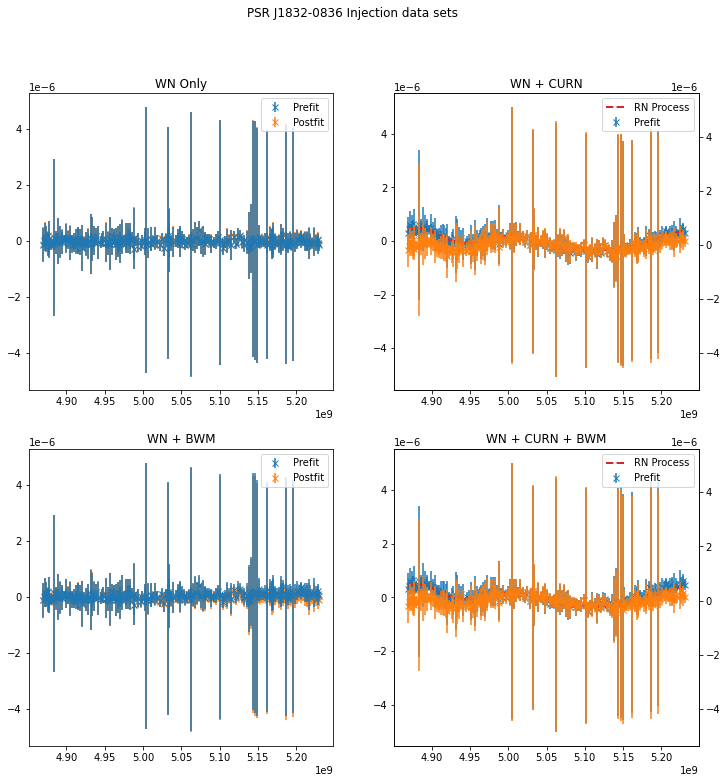

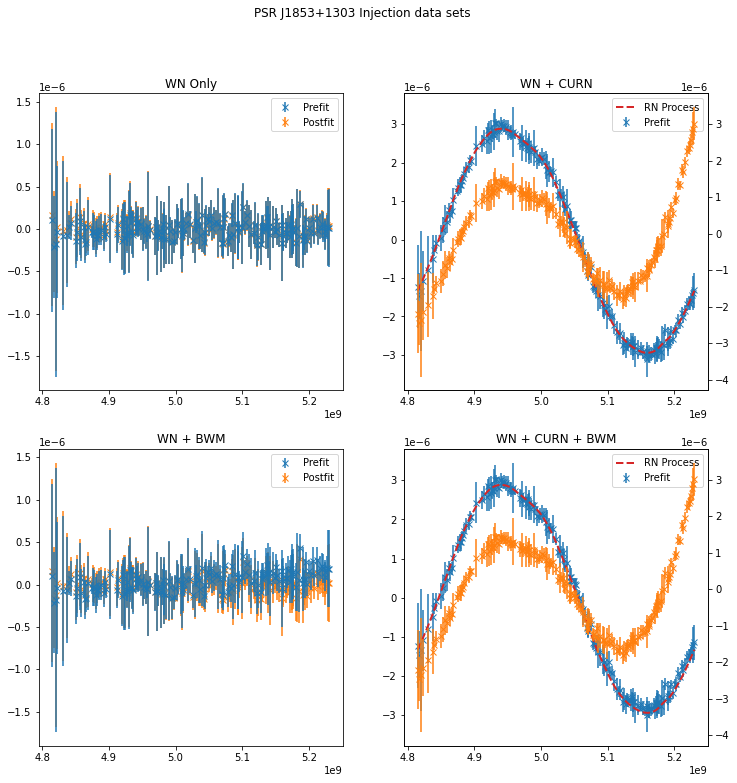

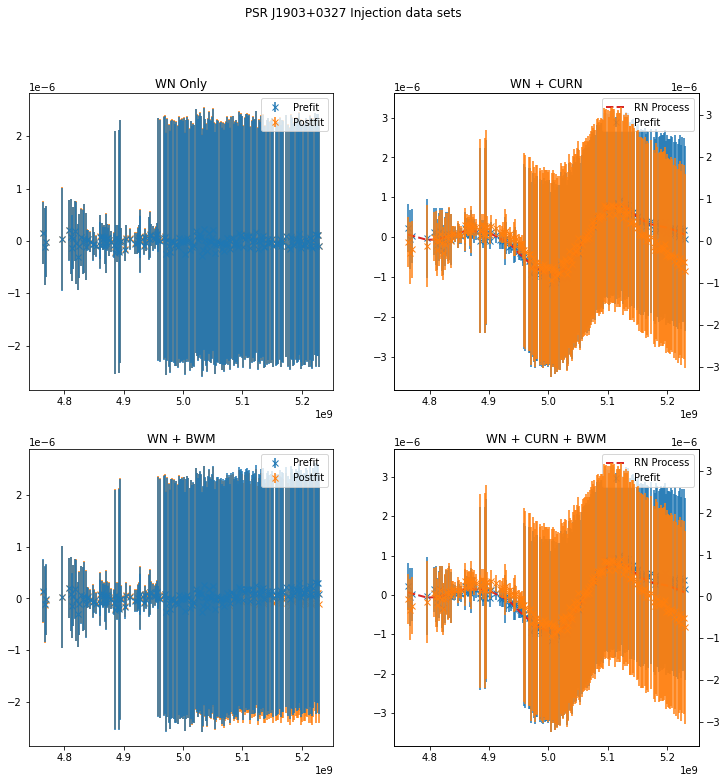

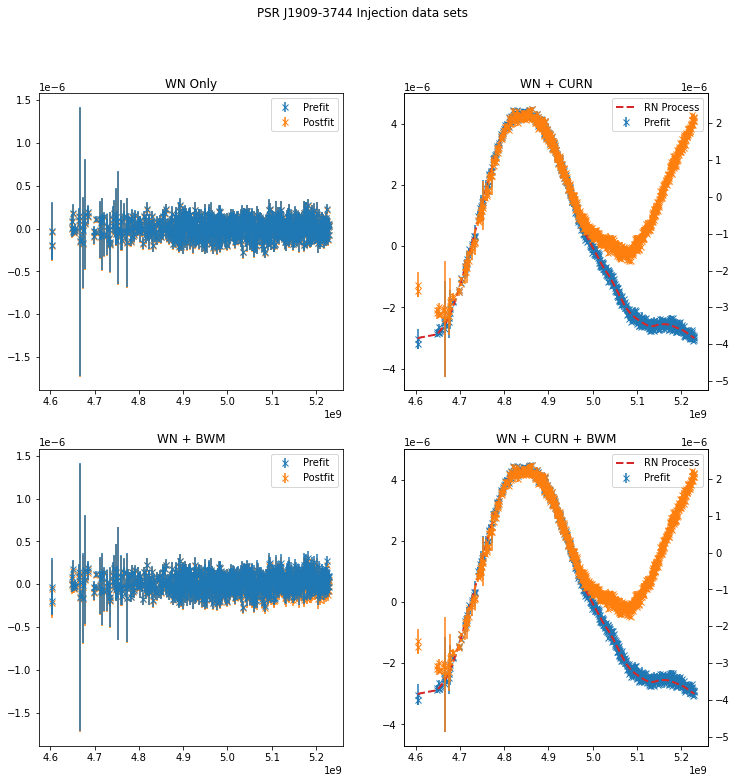

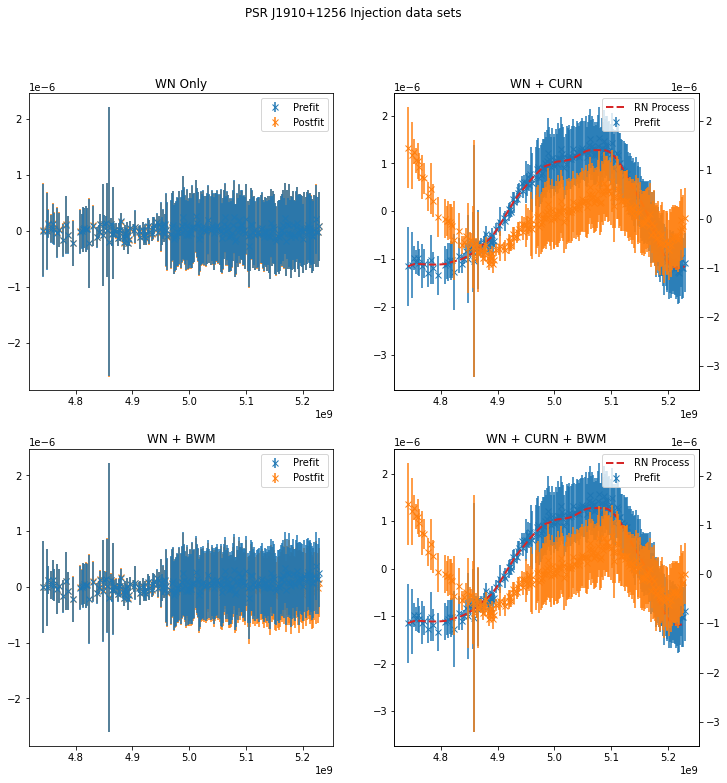

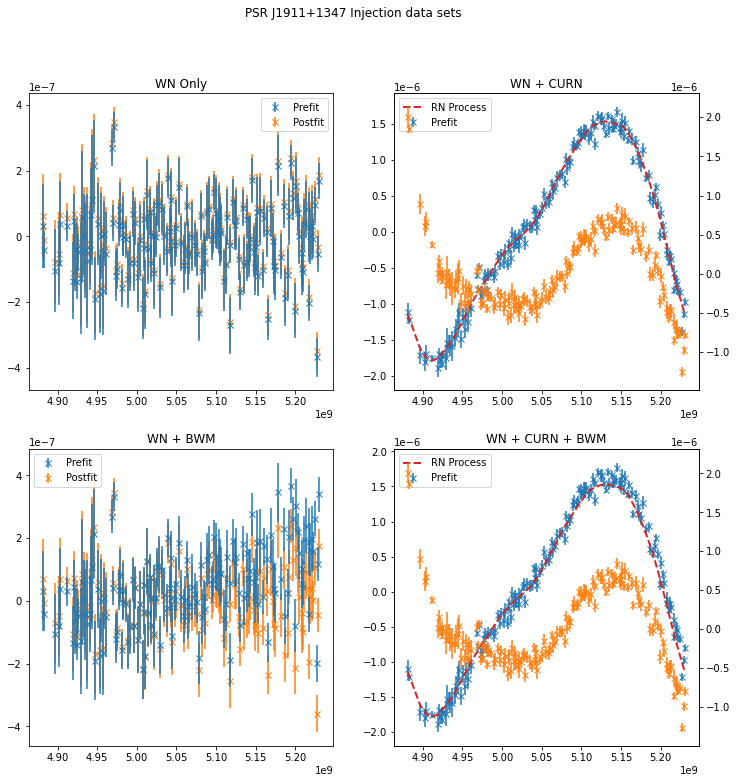

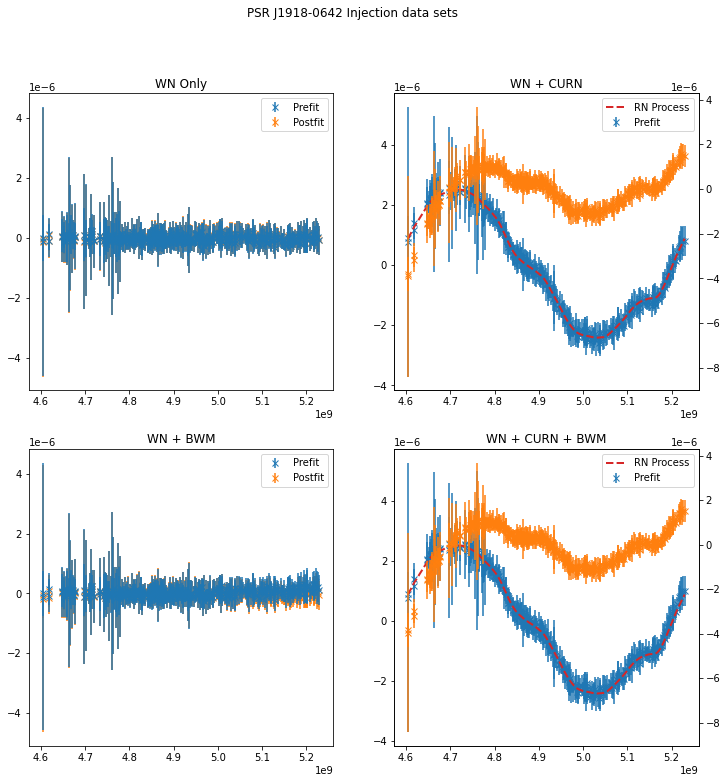

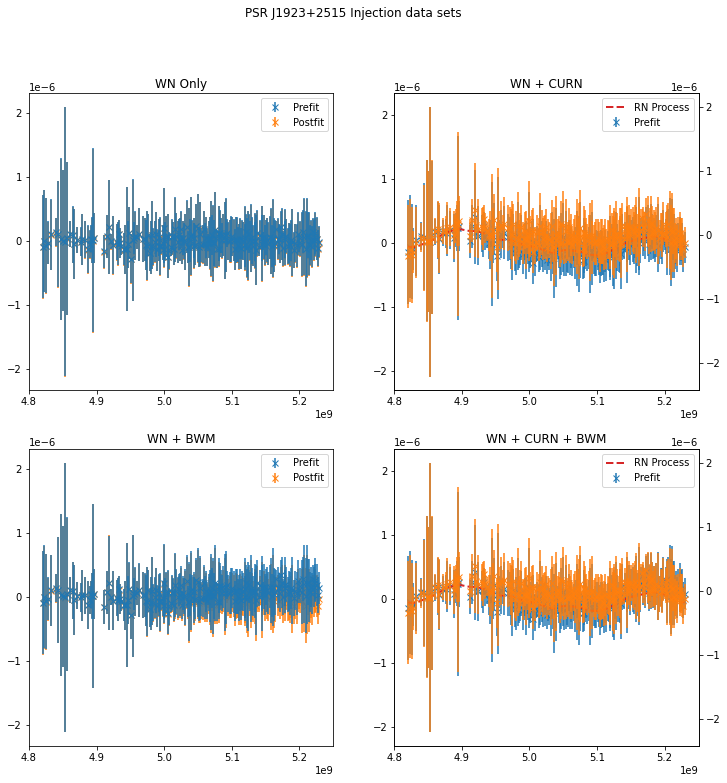

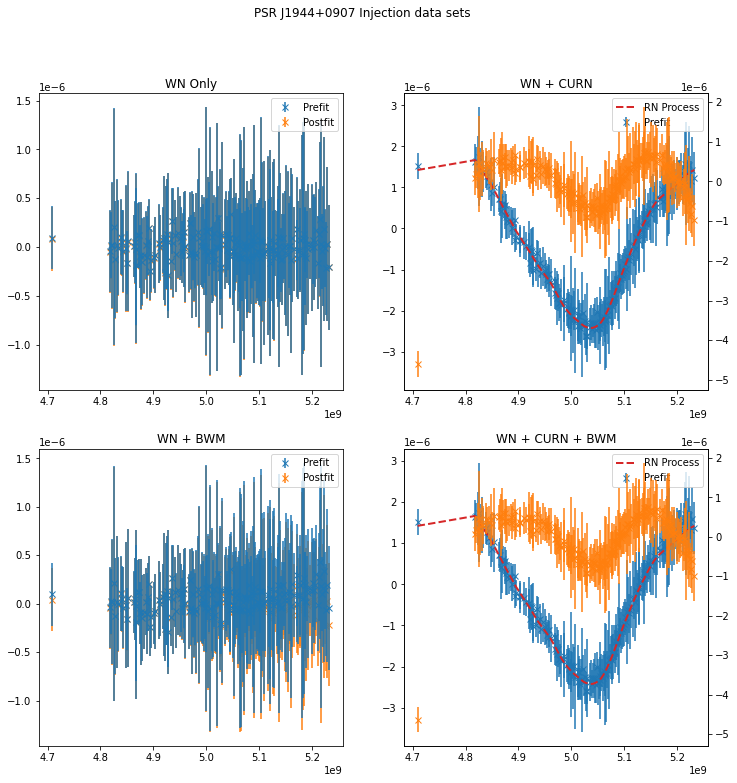

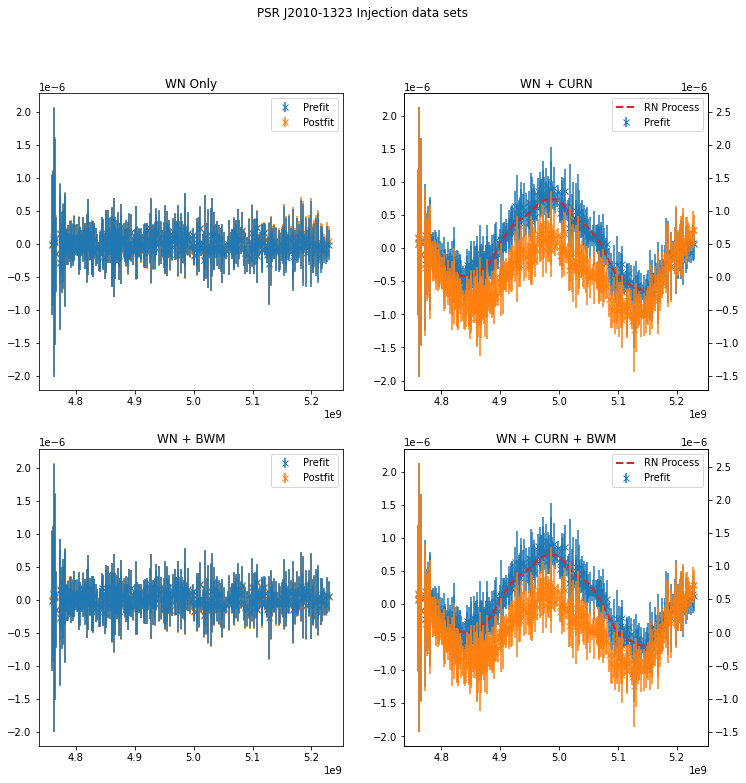

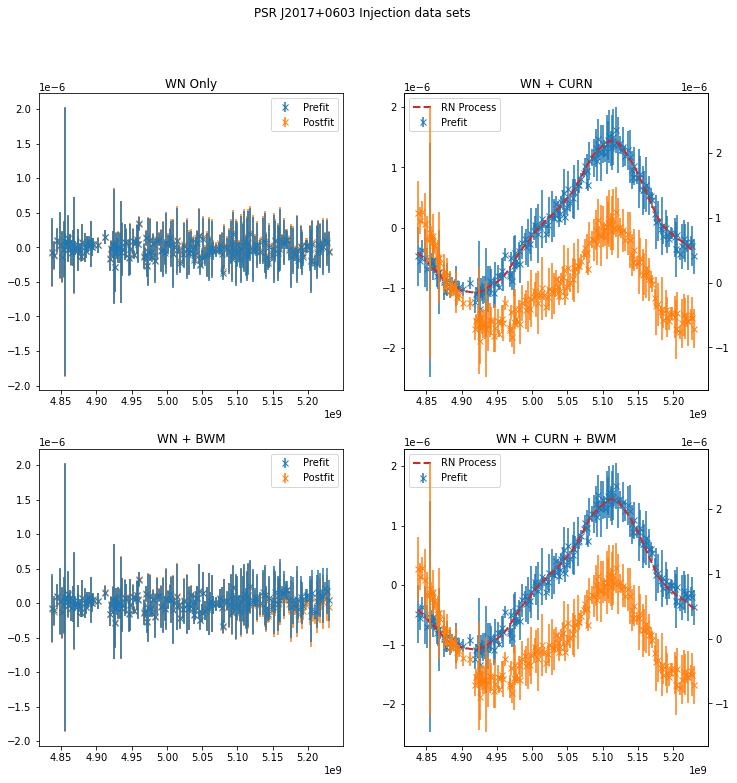

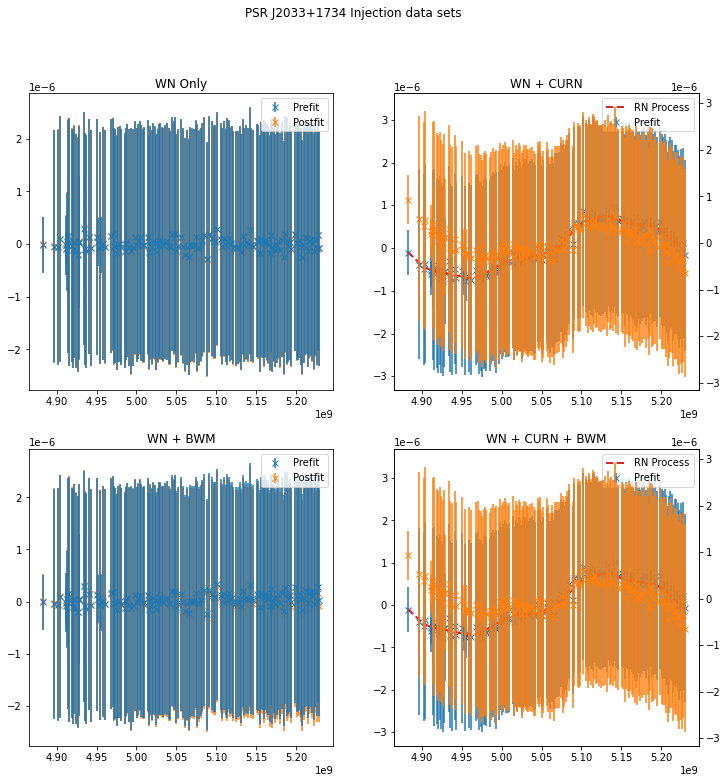

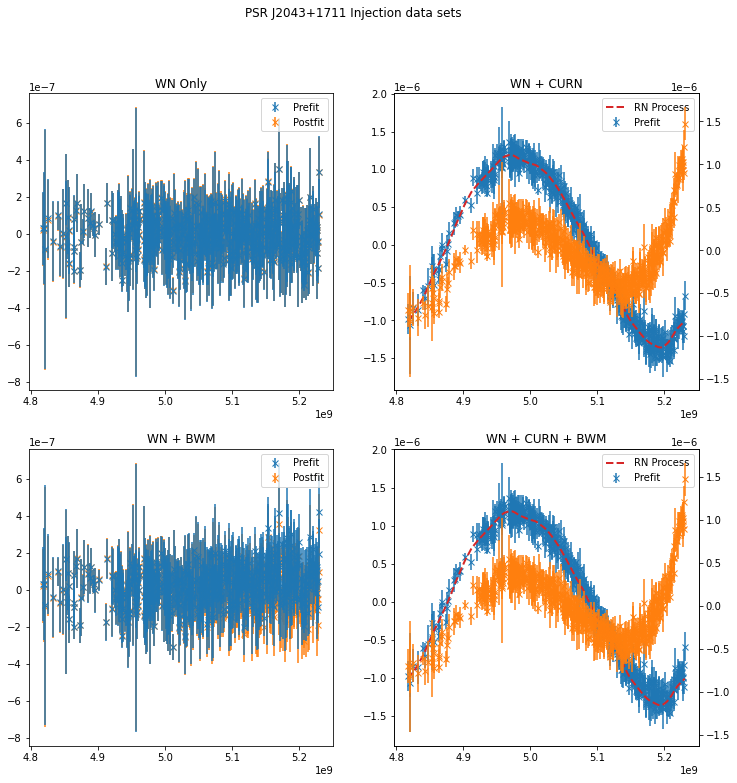

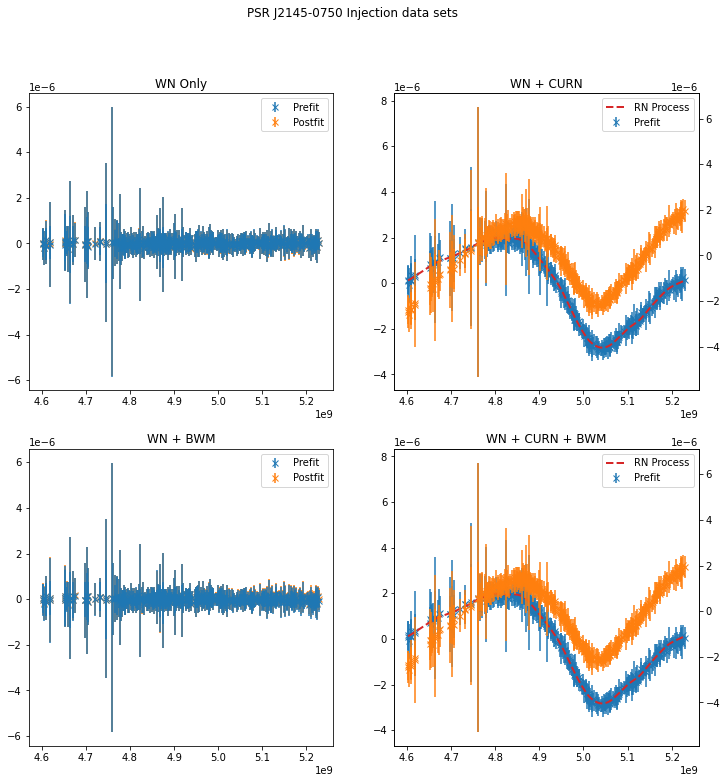

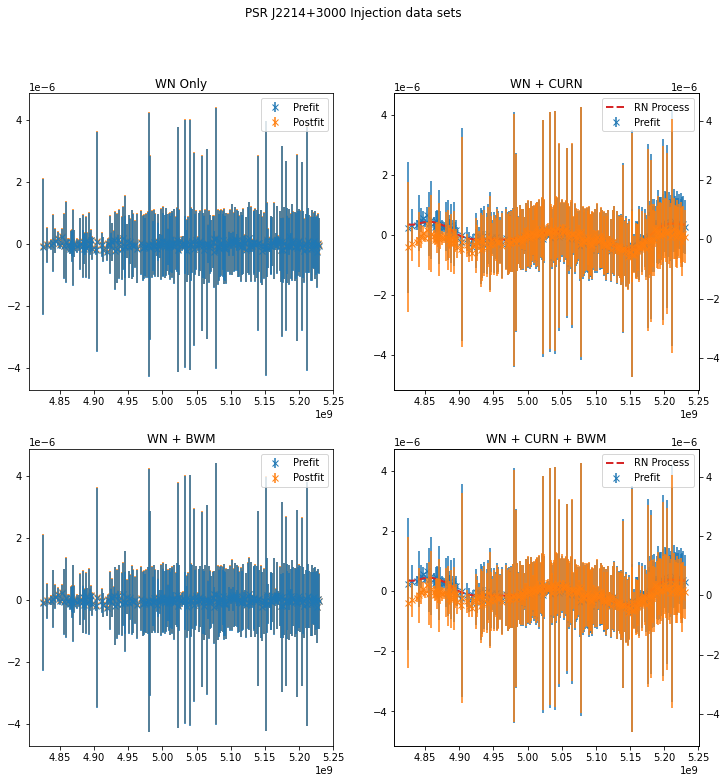

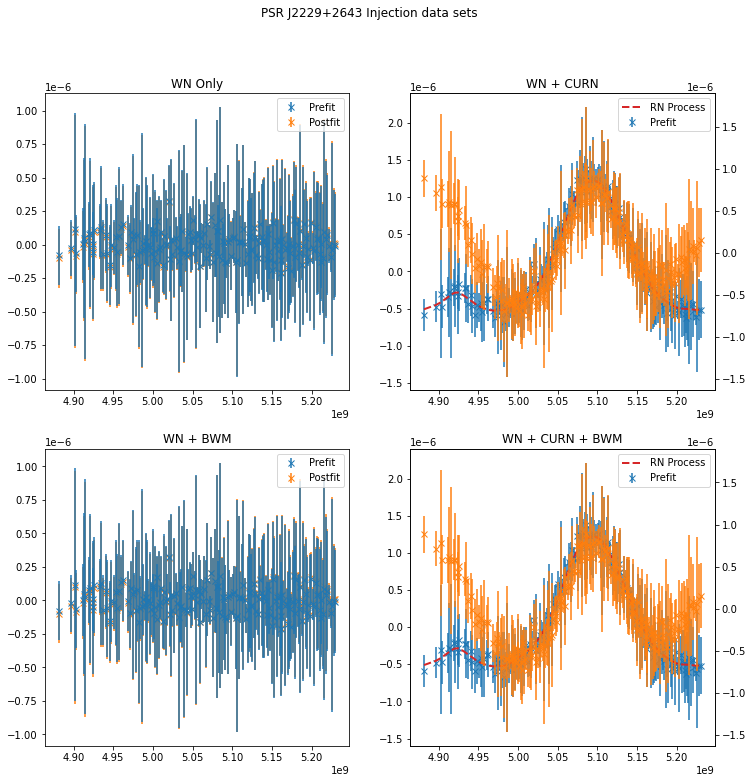

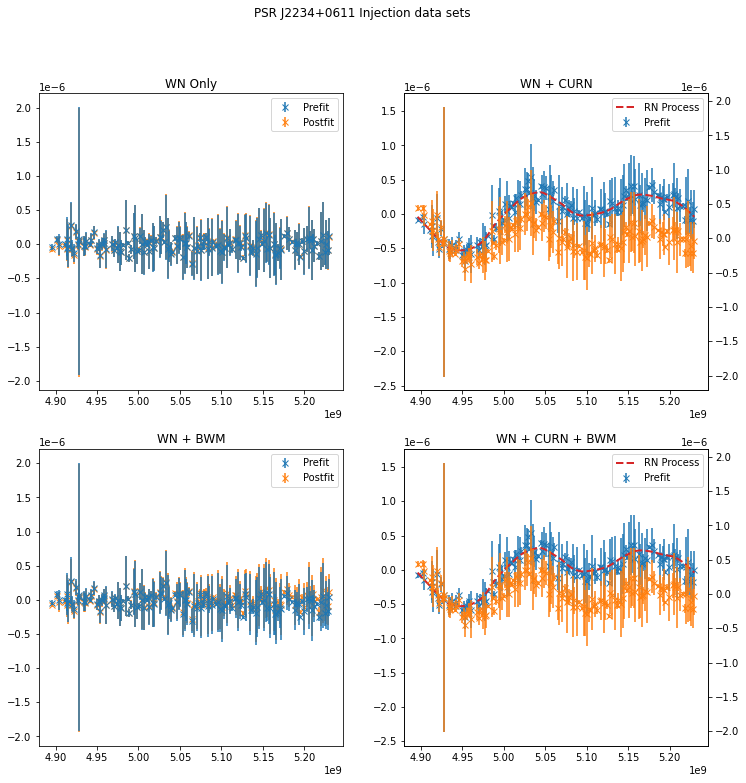

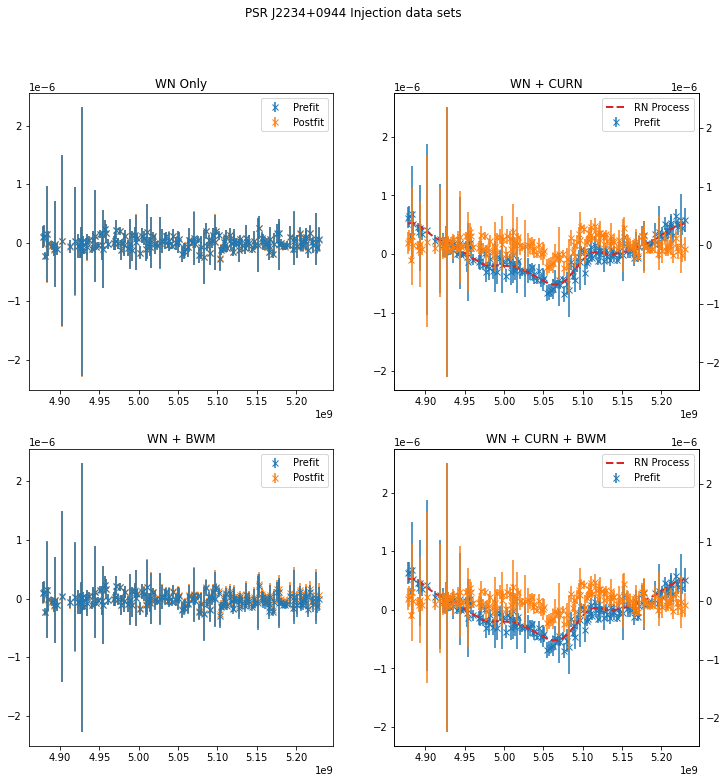

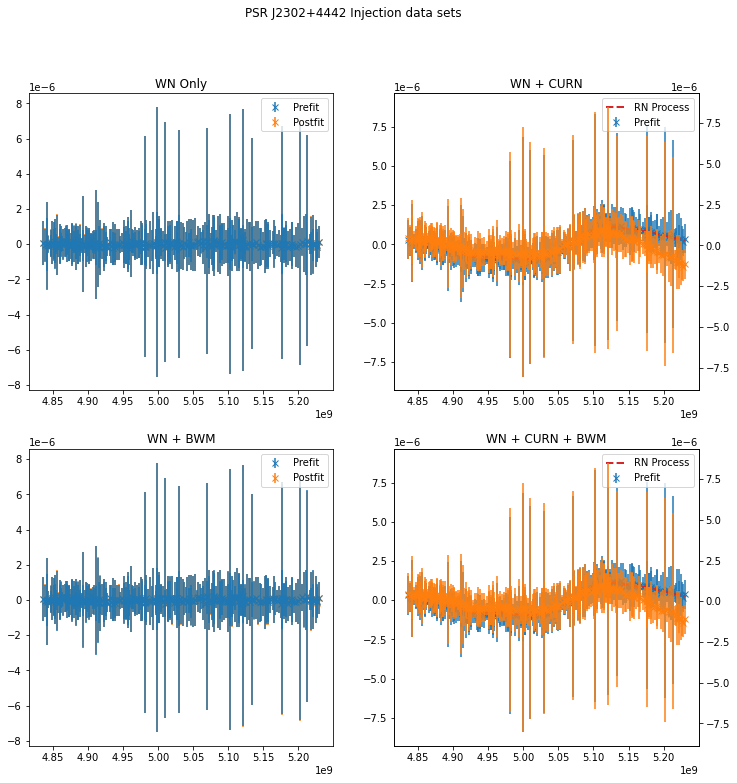

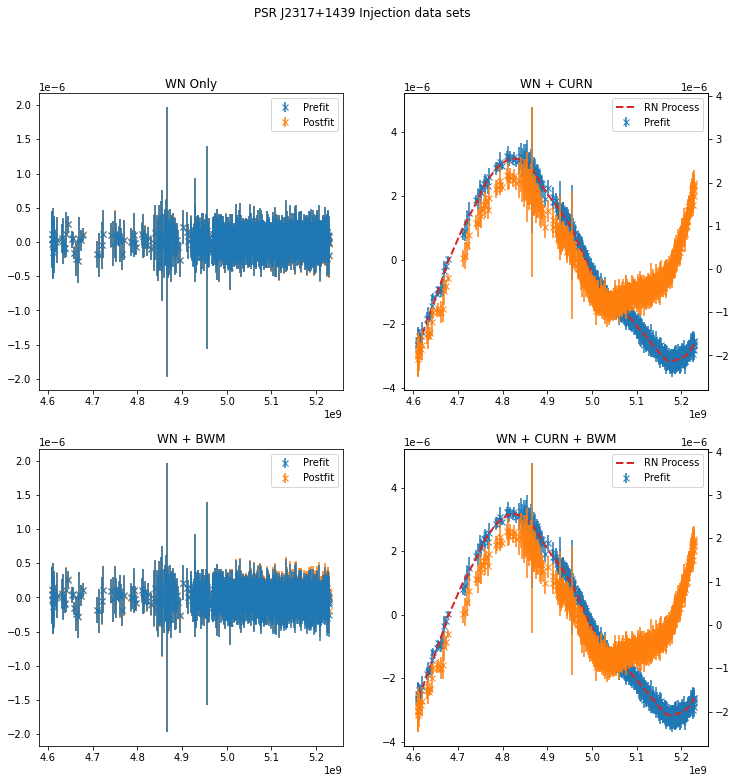

In [20]:
WN_only_psrs = [copy.deepcopy(fp) for fp in fake_psrs]
WN_CURN_psrs = [copy.deepcopy(fp) for fp in fake_psrs]
WN_BWM_psrs = [copy.deepcopy(fp) for fp in fake_psrs]
kitchen_sink_psrs = [copy.deepcopy(fp) for fp in fake_psrs]


#===================================
# BWM injection parameters
#===================================
bwm_inject_t0 = 58000
J1909 = sim_psrs[28]
print(J1909.name)
#Let's inject the burst right near J1909
J1909_theta, J1909_phi = hp.vec2ang(J1909.pos)
bwm_pol = np.pi/2
bwm_theta = J1909_theta[0] + 0.05
bwm_phi = J1909_phi[0] - 0.05

print(np.cos(bwm_theta))
print(bwm_phi)
#====================================

print("Injected BWM Params:\nPol: {}\nTheta: {}\nPhi: {}\nEpoch: {}".format(bwm_pol, bwm_theta, bwm_phi, bwm_inject_t0))


for i, psr in enumerate(fake_psrs):
    psr_tspan = psr.toas.max() - psr.toas.min()
    wn_timeseries = make_wn_timeseries(psr, wn_level=100e-9)
    rn_timeseries = make_rnseries_libstempo(psr, 2e-15, 5, ncomponents=30, Tspan=psr_tspan)
    bwm_timeseries = make_bwm_timeseries(psr, 1e-15, bwm_theta, bwm_phi, bwm_pol, bwm_inject_t0)
    
    assert WN_only_psrs[i].name == psr.name
    assert WN_CURN_psrs[i].name == psr.name
    assert WN_BWM_psrs[i].name == psr.name
    assert kitchen_sink_psrs[i].name == psr.name
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (12,12))
    plt.suptitle("PSR {} Injection data sets".format(psr.name))
    
    #print(axs)
    
    WN_only_psrs[i]._residuals += wn_timeseries
    WN_CURN_psrs[i]._residuals += wn_timeseries + rn_timeseries
    WN_BWM_psrs[i]._residuals += wn_timeseries + bwm_timeseries
    kitchen_sink_psrs[i]._residuals += wn_timeseries + rn_timeseries + bwm_timeseries
    
    axs[0,0].errorbar(WN_only_psrs[i].toas, WN_only_psrs[i].residuals, yerr = WN_only_psrs[i].toaerrs,
                    label = 'Prefit', color = 'tab:blue', ls='none', marker='x', zorder=2)
    axs[0,1].errorbar(WN_CURN_psrs[i].toas, WN_CURN_psrs[i].residuals, yerr = WN_CURN_psrs[i].toaerrs,
                    label = 'Prefit', color = 'tab:blue', ls='none', marker='x', zorder=2)
    axs[1,0].errorbar(WN_BWM_psrs[i].toas, WN_BWM_psrs[i].residuals, yerr = WN_BWM_psrs[i].toaerrs,
                    label = 'Prefit', color = 'tab:blue', ls='none', marker='x', zorder=2)
    axs[1,1].errorbar(kitchen_sink_psrs[i].toas, kitchen_sink_psrs[i].residuals, yerr = kitchen_sink_psrs[i].toaerrs,
                    label = 'Prefit', color = 'tab:blue', ls='none', marker='x', zorder=2)
    
    fit_resids(WN_only_psrs[i])
    fit_resids(WN_CURN_psrs[i])
    fit_resids(WN_BWM_psrs[i])
    fit_resids(kitchen_sink_psrs[i])
    
    axs[0,0].errorbar(WN_only_psrs[i].toas, WN_only_psrs[i].residuals, yerr = WN_only_psrs[i].toaerrs,
                    label = 'Postfit', color = 'tab:orange', ls='none', marker='x', zorder=1)
    axs[0,1].twinx().errorbar(WN_CURN_psrs[i].toas, WN_CURN_psrs[i].residuals, yerr = WN_CURN_psrs[i].toaerrs,
                    label = 'Postfit', color = 'tab:orange', ls='none', marker='x', zorder=1)
    axs[1,0].errorbar(WN_BWM_psrs[i].toas, WN_BWM_psrs[i].residuals, yerr = WN_BWM_psrs[i].toaerrs,
                    label = 'Postfit', color = 'tab:orange', ls='none', marker='x', zorder=1)
    axs[1,1].twinx().errorbar(kitchen_sink_psrs[i].toas, kitchen_sink_psrs[i].residuals, yerr = kitchen_sink_psrs[i].toaerrs,
                    label = 'Postfit', color = 'tab:orange', ls='none', marker='x', zorder=1)
    
    axs[0,1].plot(WN_CURN_psrs[i].toas, rn_timeseries, ls= '--', color='tab:red', lw=2,label='RN Process', zorder=3)
    axs[1,1].plot(kitchen_sink_psrs[i].toas, rn_timeseries, ls= '--', color='tab:red', lw=2, label='RN Process', zorder=3)
    
    axs[0,0].set_title('WN Only')
    axs[0,1].set_title('WN + CURN')
    axs[1,0].set_title('WN + BWM')
    axs[1,1].set_title('WN + CURN + BWM')
    
    
    axs[0,0].legend()
    axs[0,1].legend()
    axs[1,0].legend()
    axs[1,1].legend()
    
    
    plt.show()
# Now we need to fit each of these
    
    

In [23]:
import pickle as pkl
import numpy as np

WN_only_nparr = np.array(WN_only_psrs,dtype = 'object')
WN_CURN_nparr = np.array(WN_CURN_psrs, dtype = 'object')
WN_BWM_nparr = np.array(WN_BWM_psrs, dtype='object')
kitchen_sink_nparr = np.array(kitchen_sink_psrs, dtype='object')

WN_only_outf = './simulations/WN_only_psrs_2.pkl'
with open(WN_only_outf, 'wb+') as pklout:
    pickle.dump(WN_only_nparr, pklout)
    
WN_CURN_outf = './simulations/WN_CURN_only_psrs_2.pkl'
with open(WN_CURN_outf, 'wb+') as pklout:
    pickle.dump(WN_CURN_nparr, pklout)
    
WN_BWM_outf = './simulations/WN_BWM_late_psrs_2.pkl'
with open(WN_BWM_outf, 'wb+') as pklout:
    pickle.dump(WN_BWM_nparr, pklout)
    
kitchen_sink_outf = './simulations/kitchen_sink_BWM_late_psrs_2.pkl'
with open(kitchen_sink_outf, 'wb+') as pklout:
    pickle.dump(kitchen_sink_nparr, pklout)
    


In [24]:
type(fake_psrs[0])

enterprise.pulsar.Tempo2Pulsar

# Now let's start working on implementing the statistics

This notebook will attempt to implement a version of the Fp and Fe statistics for BWMs, following the derivation of https://arxiv.org/pdf/1204.4218.pdf

Optimal Strategies for Continuous GW Detection, Ellis, Siemens, and Creighton 2018.

function to compute A_i

In [31]:
def make_psr_bwm_shape(psr, bwm_loc, burst_epoch):
    '''
    Produces the shape vector used in Fp-Fe BWM statistic.
    Assumed that the signal is factorized in such a way that this shape carries antenna response (Fp, Fc) and time-dependent component.
    
    Parameters
    ----------
    psr (ENTERPRISE Tempo2Pulsar): The pulsar whose signal shape we want 
    bwm_loc (float, float): polar (theta) and azimuthal (phi) angles of the memory event
    burst_epoch (float): toa at which the memory wavefront crosses the Earth
    
    Returns
    ----------
    fp (float): Fp antenna response coeff
    fc (float): Fc antenna response coeff
    ramp_template (np.array of floats): The time-dependent signal shape (ramp)
    
    '''
    ramp_template = np.zeros(len(psr.toas))
    for toa_idx, toa in enumerate(psr.toas):
        ramp_template[toa_idx] = 0 if toa < burst_epoch else toa - burst_epoch
        
    apc = utils.create_gw_antenna_pattern(psr.pos, bwm_loc[0], bwm_loc[1])
    fp = apc[0]
    fc = apc[1]
    
    return fp, fc, ramp_template
    
        

Text(0.5, 1.0, 'B1855 Signal Template')

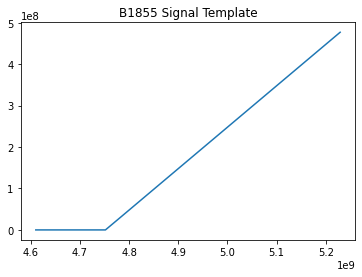

In [33]:
bwm_loc = [np.pi/3, 3 * np.pi/4]
B1855 = fake_psrs[0]
bwm_epoch = 55000 * 24 * 3600

testfp, testfc, test_shape = make_psr_bwm_shape(B1855, bwm_loc, bwm_epoch)

plt.plot(B1855.toas, test_shape)
plt.title("B1855 Signal Template")

Let's write some code which defines the inner product now

In [ ]:
def template_product(noise_cov, left_vec, right_vec):
    '''
    Computes the inner product (Eqn [32], Ellis et al 2018, Optimal Strategies)
    
    Parameters
    ----------
    noise_cov: noise covariance matrix for the full PTA
    left_vec: left-hand-side component (pre-transpose) to compute Eq [32] with
    right_vec: right-hand-side component to compute Eq [32] with 
    
    Return
    ----------
    product (float): Scalar product computed by Eq [32]

    '''
    
    left_prod = np.matmul(left_vec, noise_cov)
    product = np.matmul(left_prod, right_vec)
    return product
    

Now we need to actually compute a white noise covariance matrix to use in the product of the template with itself, <Ai|Aj>

I need to experiment with this a little bit first. Let's load up a PTA with just one pulsar (B1855+09) that has WN, BWM in the signal model

In [89]:
test_psrs = []
for psr in WN_BWM_psrs:
    if psr.name in ['B1855+09']:
        test_psrs.append(psr)
        
s = gp_signals.TimingModel(use_svd = True)

tmin = np.min([p.toas.min() for p in test_psrs])/3600/24
tmax = np.max([p.toas.max() for p in test_psrs])/3600/24

s += ee_blocks.bwm_block(tmin, tmax, logmin=-18, logmax=-12, amp_prior = 'log-uniform', skyloc=(np.cos(bwm_loc[0]), bwm_loc[1]))
s += ee_blocks.white_noise_block(vary=True, inc_ecorr=False, select='none')

models = []
for p in test_psrs:
    models.append(s(p))
    
test_pta = signal_base.PTA(models)


In [90]:
B1855_ndiag = test_pta.get_ndiag()
print(len(ndiag[0]))

print(ndiag[0])

219
[6.74436592e-13 3.17590849e-14 3.95459321e-14 6.67589000e-13
 6.71205024e-13 6.66004961e-13 3.79457446e-13 7.52534805e-13
 8.38350114e-13 1.49923185e-13 3.75074281e-14 2.76892100e-14
 9.45669290e-15 1.37960209e-14 7.42745225e-14 1.62900176e-14
 6.83567876e-14 2.59759396e-14 5.92851584e-14 1.31615022e-13
 5.89208009e-14 7.86624841e-14 1.38288089e-14 6.62777403e-13
 3.85591321e-14 7.67546082e-13 6.78612961e-14 4.96285025e-14
 2.03898074e-13 1.27506164e-13 1.17330912e-13 4.99227041e-14
 3.30023321e-14 6.80444529e-13 8.77506890e-13 7.05985629e-13
 6.89431668e-13 7.60135240e-13 1.00843731e-12 7.09047160e-13
 1.26158839e-12 6.79257292e-13 7.81202440e-13 7.21886176e-13
 7.90403220e-13 7.62194080e-13 7.78288623e-13 3.27043804e-13
 8.79826025e-14 1.81022622e-13 4.12643521e-14 4.83477746e-12
 4.82058371e-12 5.78873521e-14 5.43004961e-14 7.29082289e-14
 5.48934464e-14 5.53203001e-14 5.71063376e-14 5.93484281e-14
 4.82510763e-12 6.06701321e-14 6.10201124e-14 4.83381004e-12
 5.21250481e-14 4.82

We can compute the fitted WN matrices by using the R matrix, and then computing the covariance matrix which can be used in the inner product.
This may be only computed once, since the toas remain the same for any particular signal, but I think we have to recompute before each run.

Let's make a noise covariance matrix

In [103]:
B1855_rmat = make_Rmat(B1855)

diagonal_wn_mtx = np.diag(B1855_ndiag[0])

B1855_Rn = np.array(B1855_rmat) @ diagonal_wn_mtx @ np.array(B1855_rmat).T

We now have the timing-model marginalized noise covariance matrix for a PTA with *just* B1855. See Eqn [28] from Ellis et al 2018, Optimal Strategies.